# Import Package

In [1]:
# Import Package
import re
import numpy as np
import seaborn as sns
import json
import time
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import geopandas
import matplotlib.pyplot as plt
import folium
import pandas as pd

# Import Data

In [2]:
# Read Data Hasil Scrapping
df_cimahi = pd.read_excel('Data_Rumah_Cimahi_Cleaned.xlsx')
df_bandung = pd.read_excel('Data_Rumah_Bandung_Cleaned.xlsx')

In [3]:
# Read data peta dengan GeoPandas
df = geopandas.read_file("Jabar_By_Kec.geojson")

# Filter Kota Cimahi dan Kota Bandung
cimahi = df[df['KABKOT'] == 'KOTA CIMAHI']
bandung = df[df['KABKOT'] == 'KOTA BANDUNG']

# Buat koordinat
cimahi['coords'] = cimahi['geometry'].apply(lambda x: x.representative_point().coords[:])
cimahi['coords'] = [coords[0] for coords in cimahi['coords']]
bandung['coords'] = bandung['geometry'].apply(lambda x: x.representative_point().coords[:])
bandung['coords'] = [coords[0] for coords in bandung['coords']]

C:\Users\ASUS\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ASUS\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [4]:
# Filter Kecamatan yang ada di Bandung
df_bandung = df_bandung[df_bandung['Kecamatan'].isin(bandung['KECAMATAN'].unique())].reset_index(drop = True)

# Analisis Data
Bagian ini akan dibagi menjadi 3 yakni, 
* Analisis harga rumah di Kota Cimahi, 
* Analisis harga rumah di Kota Bandung,
* Analisis harga rumah di Kota Cimahi dan Bandung

## Kota Cimahi

### Harga Rumah di Kota Cimahi

In [5]:
# Lihat Statistika Deskriptif berdasarkan Kota
df_cimahi['Harga'].describe().to_frame()

,Harga
count,2.600000e+03
mean,1.707840e+09
std,2.863489e+09
min,1.750000e+06
25%,6.950000e+08
50%,1.000000e+09
75%,1.700000e+09
max,8.000000e+10


Dari informasi di atas diperoleh bahwa, 
* Rerata harga rumah di wilayah Cimahi adalah 1.71 miliar rupiah,
* Harga rumah minimum yang dapat diperoleh di wilayah Cimahi adalah 1.75 juta rupiah,
* Harga rumah maksimum yang dapat diperoleh di wilayah Cimahi adalah 80 miliar rupiah

In [6]:
# Rumah dengan harga minimum
minimum_house_price = df_cimahi[df_cimahi['Harga'] == df_cimahi['Harga'].min()]
minimum_house_price

,Nama,Lokasi,Harga,Jumlah Kamar Tidur,Jumlah Kamar Mandi,Total Area,Harga per Area,Jenis Properti,Sertifikat Rumah,Tanggal Posting,Nama Agen,Link,Provinsi,Kota,Kecamatan,Jalan
274,Rumah Baru di Jantung Kota Cimahi Bandung,"Cimahi Tengah, Cimahi, Jawa Barat",1750000,3,3.0,120,14463,Rumah,SHGB - Hak Guna Bangunan,2023-07-29 06:44:00.000000,Velicia Surjadi,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,CIMAHI,CIMAHI TENGAH,CIMAHI TENGAH


Rumah dengan 3 kamar tidur dan 3 kamar mandi tapi dengan harga 1.75 juta sangat langka, terutama apabila dilihat di peta, rumah ini terletak di samping jalan raya

In [7]:
# Rumah dengan harga maksimum
maximum_house_price = df_cimahi[df_cimahi['Harga'] == df_cimahi['Harga'].max()]
maximum_house_price

,Nama,Lokasi,Harga,Jumlah Kamar Tidur,Jumlah Kamar Mandi,Total Area,Harga per Area,Jenis Properti,Sertifikat Rumah,Tanggal Posting,Nama Agen,Link,Provinsi,Kota,Kecamatan,Jalan
898,Jual Hotel Bintang 2 Aktif di Jalan Raya Cibeu...,"Jalan Raya Cibeureum, Cimahi Selatan, Cimahi, ...",80000000000,10,10.0,6846,11968881,Rumah,SHM - Sertifikat Hak Milik,2023-08-02 06:23:00.000000,Chandra .,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,CIMAHI,CIMAHI SELATAN,JALAN RAYA CIBEUREUM


Hotel dijual? Menarik, harganya bisa sampe 80 Miliar

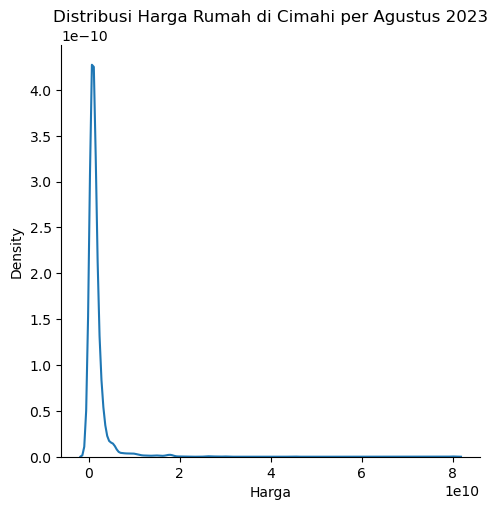

In [8]:
# Lihat distribusi harga
sns.displot(data = df_cimahi,
            kind = 'kde',
            x = 'Harga')
plt.title('Distribusi Harga Rumah di Cimahi per Agustus 2023')
plt.show()

Cukup sulit untuk melihat distribusi harga jika disertai pencilan, tinjau apabila pencilan dihapus dengan metode IQR

In [9]:
def iqr_outlier_removal(data, column):
    # Hitung Q1 dan Q3
    q1, q3 = data[column].quantile(0.25), data[column].quantile(0.75)
    
    # Hitung IQR
    iqr = q3 - q1
    
    # Hitung batas atas dan batas bawah
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    
    # Filter outlier index
    outliers = data[(data[column] > upper) | (data[column] < lower)].index
    
    # Return index
    return outliers

In [10]:
# Tentukan observasi pencilan dengan menggunakan fungsi di atas
outlier_index = iqr_outlier_removal(df_cimahi, 'Harga')

# Buang observasi pencilan tersebut 
non_outliers_cimahi = df_cimahi.drop(outlier_index)

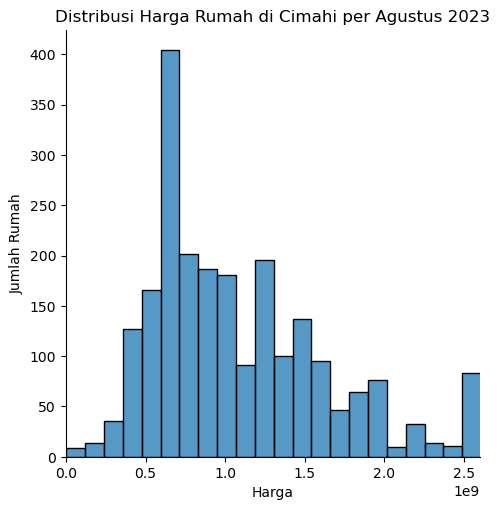

In [11]:
# Lihat distribusi harga non outliers
sns.displot(data = non_outliers_cimahi,
            kind = 'hist',
            x = 'Harga')
plt.title('Distribusi Harga Rumah di Cimahi per Agustus 2023')
plt.ylabel('Jumlah Rumah')
plt.xlim(0, 2.6e9)
plt.show()

Mayoritas harga rumah yang dijual di Cimahi ada di kisaran Rp 500 - 700 juta

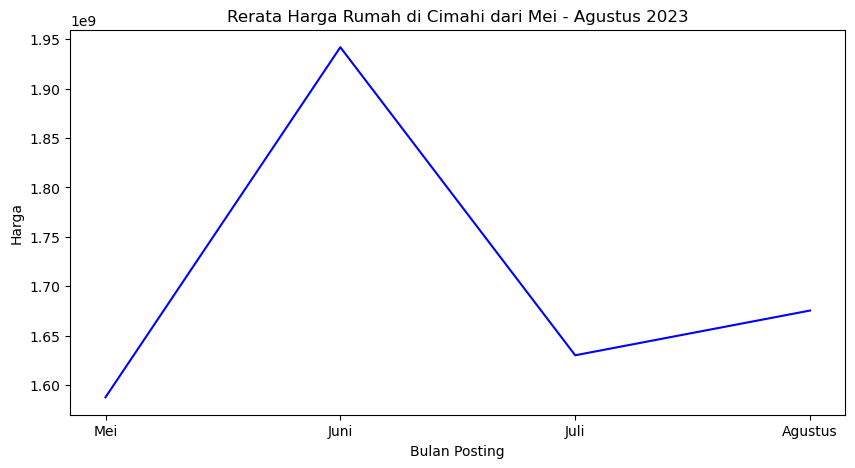

In [12]:
# Lihat pergerakan harga rumah di Cimahi
# Dapatkan informasi bulan posting penjualan rumah
df_cimahi['Bulan Posting'] = pd.to_datetime(df_cimahi['Tanggal Posting']).dt.month

# Agregat data berdasarkan bulan posting, hitung rerata harganya
harga_per_tanggal = df_cimahi.groupby(['Bulan Posting'], as_index = False)['Harga'].mean()

# Untuk memudahkan penamaan bulan, konversi bilangan ID bulan ke nama bulan bersangkutan
harga_per_tanggal['Bulan Posting'] = harga_per_tanggal['Bulan Posting'].map({5:'Mei', 6:'Juni', 7:'Juli', 8:'Agustus'})

# Visualisasikan
plt.figure(figsize = (10, 5))
sns.lineplot(data = harga_per_tanggal,
            x = 'Bulan Posting',
            color = 'blue',
            markers = True,
            y = 'Harga')
plt.title('Rerata Harga Rumah di Cimahi dari Mei - Agustus 2023')
plt.show()

Tampaknya pada bulan Juni 2023, rerata harga rumah di Cimahi mencapai titik tertinggi yakni sekitar Rp 1.95 M (hampir 2 M)

### Harga Rumah di Kota Cimahi

In [13]:
# Mean, Min, Max berdasarkan kecamatan
harga_per_kecamatan_cimahi = df_cimahi.groupby(['Kecamatan'])['Harga'].agg(['count', 'mean','min','max']).drop('LAINNYA').reset_index()
harga_per_kecamatan_cimahi = harga_per_kecamatan_cimahi.rename(columns = {'count':'Jumlah Rumah',
                                                                         'mean':'Rerata Harga (Rp)',
                                                                         'min':'Harga minimum (Rp)',
                                                                         'max':'Harga maksimum (Rp)'})

# Buat Tampilan yang lebih cantik
s = harga_per_kecamatan_cimahi.style.highlight_max(color='pink').format(precision=0, thousands=".", decimal=",")

cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'background-color: #000066; font-style: bold; color: white; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #000066; color: white;'
}

s.set_table_styles([cell_hover, index_names, headers])

,Kecamatan,Jumlah Rumah,Rerata Harga (Rp),Harga minimum (Rp),Harga maksimum (Rp)
0,CIMAHI SELATAN,349,2.005.802.267,30.000.000,80.000.000.000
1,CIMAHI TENGAH,566,1.979.851.902,1.750.000,45.000.000.000
2,CIMAHI UTARA,1.684,1.554.787.847,150.000.000,28.000.000.000


Secara rata-rata, harga rumah di Cimahi Selatan paling mahal dibandingkan kedua kecamatan lainnya, tetapi jumlah rumah di Cimahi Utara paling banyak dibandingkan ketiga wilayah

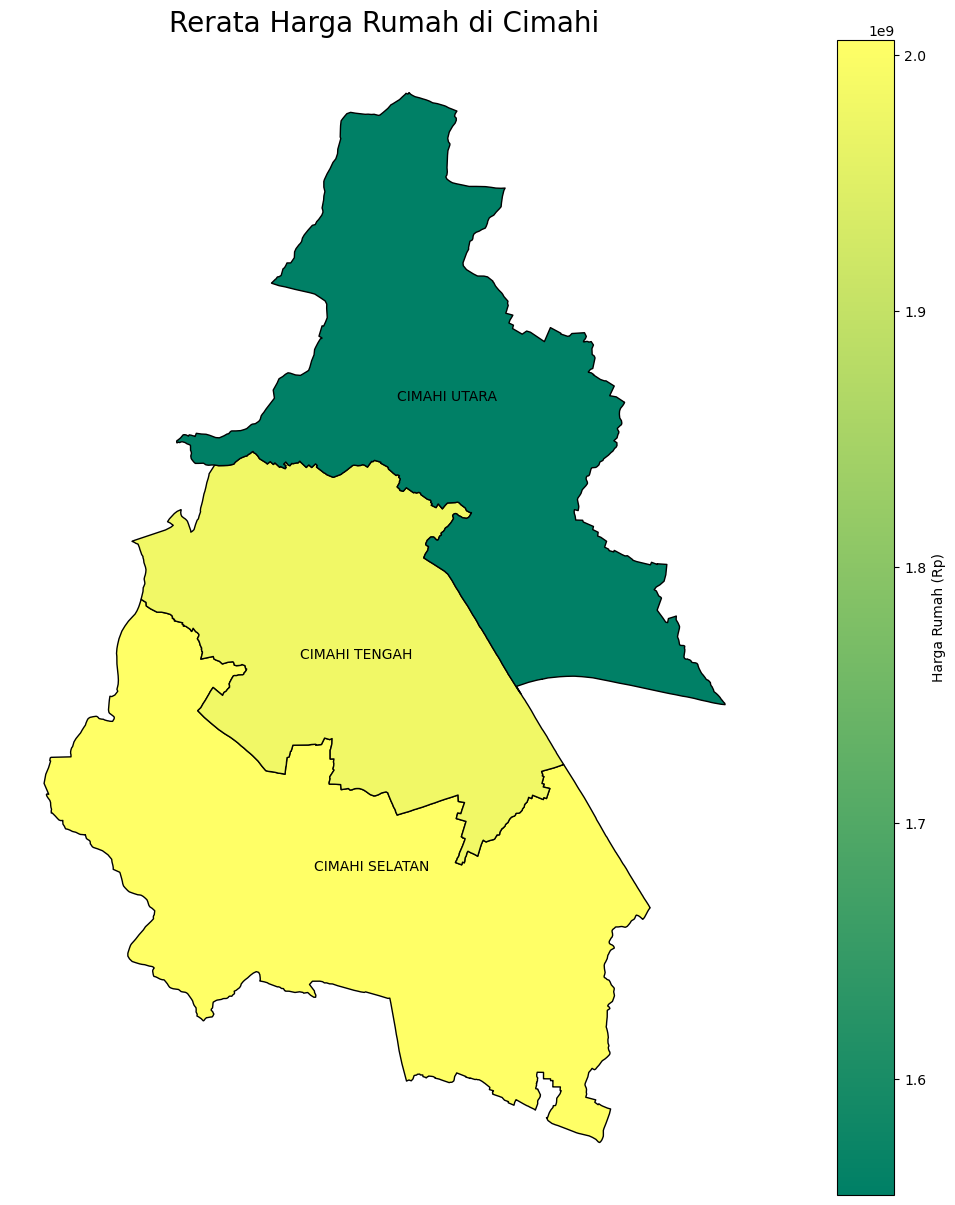

In [14]:
# Merge dengan harga rata-rata di Cimahi
cimahi_vis = cimahi.merge(harga_per_kecamatan_cimahi, 
                          left_on = 'KECAMATAN', 
                          right_on = 'Kecamatan', 
                          how = 'inner')

# Visualisasikan Peta
cimahi_vis.plot(column="Rerata Harga (Rp)", 
                figsize = (20,15), 
                cmap="summer", 
                edgecolor="k", 
                legend=True,
               legend_kwds={"label": "Harga Rumah (Rp)"})
# Anotasi nama kecamatan
for idx, row in cimahi_vis.iterrows():
    plt.annotate(text=row['KECAMATAN'], xy=row['coords'], horizontalalignment='center')

plt.title('Rerata Harga Rumah di Cimahi', fontsize = 20)
plt.axis('off')
plt.show()

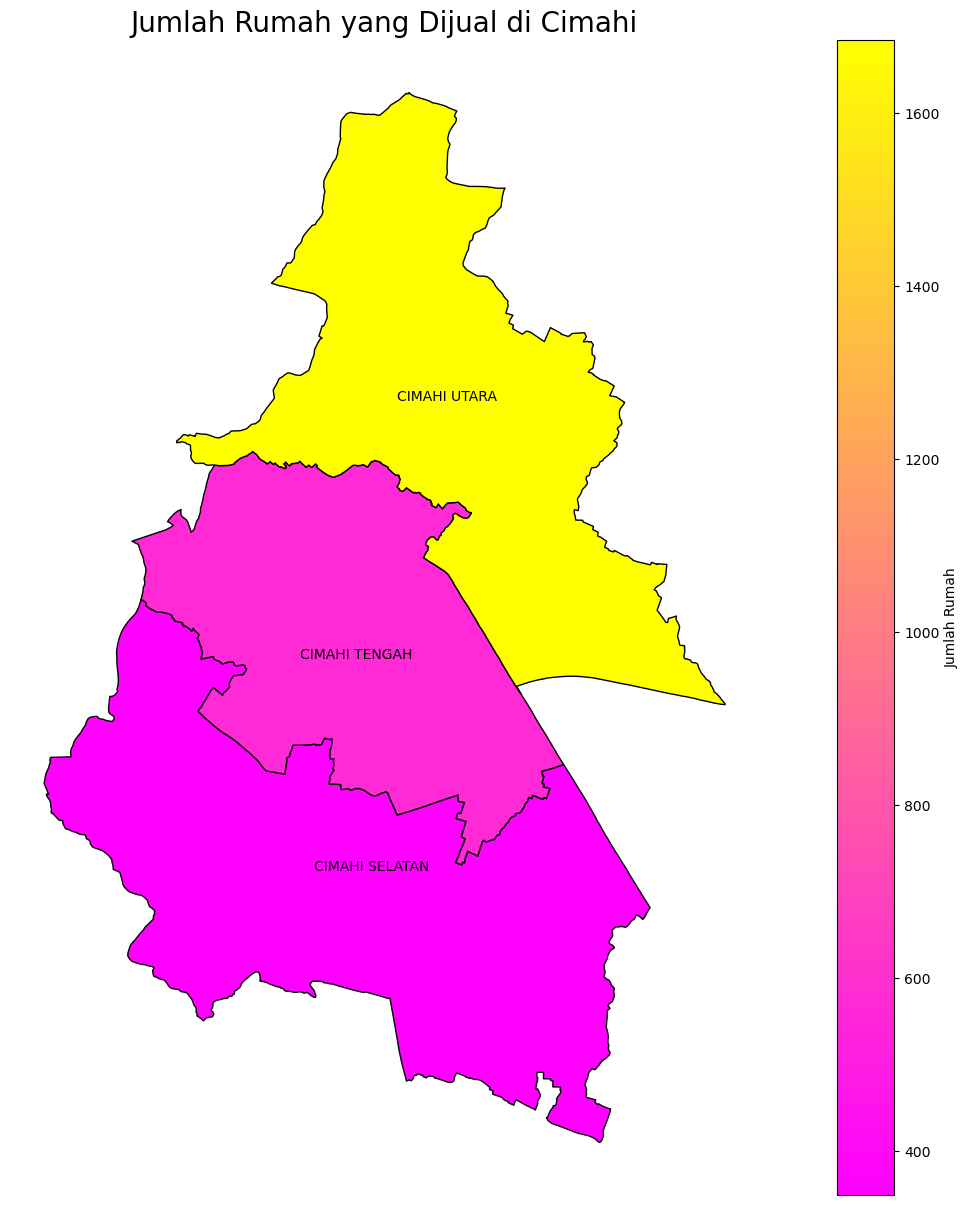

In [15]:
# Visualize jumlah rumah
cimahi_vis.plot(column="Jumlah Rumah", 
                figsize = (20,15), 
                cmap="spring", 
                edgecolor="k", 
                legend=True,
               legend_kwds={"label": "Jumlah Rumah"})
for idx, row in cimahi_vis.iterrows():
    plt.annotate(text=row['KECAMATAN'], 
                 xy=row['coords'], 
                 xytext = row['coords'],
                 horizontalalignment='center')
plt.title('Jumlah Rumah yang Dijual di Cimahi', fontsize = 20)
plt.axis('off')
plt.show()

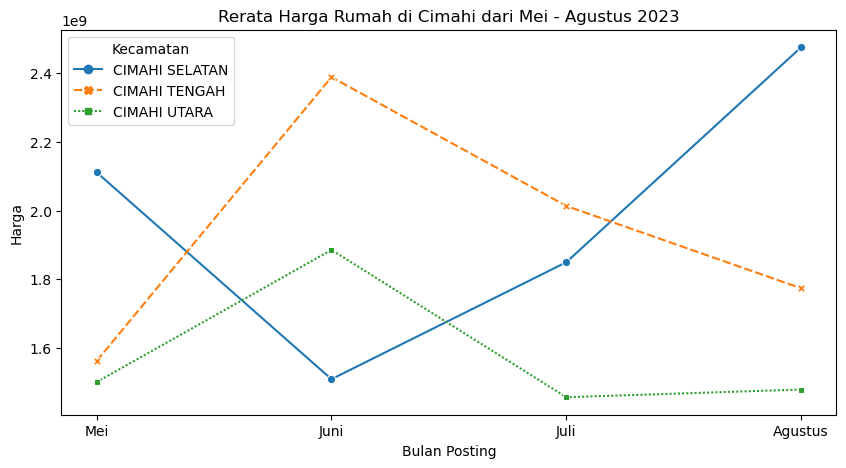

In [16]:
# Deret waktu harga rumah di Cimahi
harga_per_tanggal = df_cimahi.groupby(['Bulan Posting','Kecamatan'], as_index = False)['Harga'].mean()
harga_per_tanggal = harga_per_tanggal[harga_per_tanggal['Kecamatan'] != 'LAINNYA']
harga_per_tanggal['Bulan Posting'] = harga_per_tanggal['Bulan Posting'].map({5:'Mei', 6:'Juni', 7:'Juli', 8:'Agustus'})

# Visualize
plt.figure(figsize = (10, 5))
sns.lineplot(data = harga_per_tanggal,
            x = 'Bulan Posting',
            y = 'Harga',
            hue = 'Kecamatan',
            markers=True,
            style = 'Kecamatan')
plt.title('Rerata Harga Rumah di Cimahi dari Mei - Agustus 2023')
plt.show()

Tampaknya harga rumah di Cimahi Selatan terus menaik dari bulan Juni 2023

### Luas Bangunan Rumah di Kota Cimahi

In [17]:
# Lihat Statistika Deskriptif berdasarkan Luas Rumah
df_cimahi['Total Area'].describe().to_frame()

,Total Area
count,2600.000000
mean,172.481923
std,1484.129030
min,30.000000
25%,65.000000
50%,100.000000
75%,165.000000
max,75150.000000


Dari statistika deskriptif tersebut diperoleh:
* Rerata luas rumah di Cimahi adalah 172 m²
* Minimum luas rumah di Cimahi adalah 30 m²
* Maksimum luas rumah di Cimahi adalah 75150 m²

In [18]:
# Rumah dengan luas minimum
minimum_total_area = df_cimahi[df_cimahi['Total Area'] == df_cimahi['Total Area'].min()].reset_index(drop = True)
print('Rerata Harga:', minimum_total_area['Harga'].mean())
minimum_total_area

Rerata Harga: 277846153.84615386


,Nama,Lokasi,Harga,Jumlah Kamar Tidur,Jumlah Kamar Mandi,Total Area,Harga per Area,Jenis Properti,Sertifikat Rumah,Tanggal Posting,Nama Agen,Link,Provinsi,Kota,Kecamatan,Jalan,Bulan Posting
0,RumahBaru Murah 300 Jutaan Dekat Kampus Polban,"Jalan Cigugur Girang, Cimahi Utara, Cimahi, Ja...",350000000,2,1.0,30,5833333,Rumah,SHM - Sertifikat Hak Milik,2023-08-01 06:44:00.000000,Aisy .,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,CIMAHI,CIMAHI UTARA,JALAN CIGUGUR GIRANG,8
1,Cimahi,"Bandung, Cimahi Tengah, Cimahi, Jawa Barat",167000000,2,1.0,30,3711111,Rumah,SHM - Sertifikat Hak Milik,2023-07-28 06:44:00.000000,Mochamad Nanda,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,CIMAHI,CIMAHI TENGAH,BANDUNG,7
2,Permata Cimahi,". Jl. Raya Gadobangkong, Cimareme, Cimahi Utar...",180000000,2,1.0,30,4,Rumah,SHM - Sertifikat Hak Milik,2023-07-31 06:44:00.000000,Syahrul Febriant,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,CIMAHI,CIMAHI UTARA,. JL. RAYA GADOBANGKONG,7
3,Jarang Ada Rumah Masuk Mobil di kota Cimahi se...,"Cimahi Utara, Cimahi, Jawa Barat",290000000,2,1.0,30,6904762,Rumah,AJB - Akta Jual Beli,2023-08-01 21:44:00.000000,Susi Sulistianti,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,CIMAHI,CIMAHI UTARA,CIMAHI UTARA,8
4,Permata Cimahi,". Jl. Raya Gadobangkong, Cimareme, Cimahi Utar...",190000000,2,1.0,30,3800000,Rumah,SHM - Sertifikat Hak Milik,2023-07-30 06:44:00.000000,HARIS HIDAYAT,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,CIMAHI,CIMAHI UTARA,. JL. RAYA GADOBANGKONG,7
5,Rumah Murah Minimalis Dekat Pusat Perkotaan,"Jalan Terusan Cibaduyut, Cimahi Selatan, Cimah...",180000000,2,1.0,30,3600000,Rumah,AJB - Akta Jual Beli,2023-07-30 06:44:00.000000,Ridwan Rahayu,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,CIMAHI,CIMAHI SELATAN,JALAN TERUSAN CIBADUYUT,7
6,Jual Rumah Termurah Se-kota Cimahi Masuk Mobil,"Cimahi Utara, Cimahi, Jawa Barat",350000000,2,1.0,30,8333333,Rumah,SHM - Sertifikat Hak Milik,2023-08-02 06:37:00.000000,Susi Sulistianti,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,CIMAHI,CIMAHI UTARA,CIMAHI UTARA,8
7,Rumah Baru di Cluster Cigugur Indah Dekat Gege...,"Jl Cigugur Girang Parongpong, Cimahi Utara, Ci...",331000000,2,1.0,30,5910714,Rumah,SHM - Sertifikat Hak Milik,2023-08-02 06:23:00.000000,Muhammad Baskara,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,CIMAHI,CIMAHI UTARA,JL CIGUGUR GIRANG PARONGPONG,8
8,DIJUAL CEPAT RUMAH CLUSTER CIGUGUR HARGA MURAH...,"Jl Cigugur Girang Parongpong Bandun Barat, Cim...",344000000,2,1.0,30,6142857,Rumah,SHM - Sertifikat Hak Milik,2023-08-02 06:23:00.000000,Muhammad Baskara,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,CIMAHI,CIMAHI UTARA,JL CIGUGUR GIRANG PARONGPONG BANDUN BARAT,8
9,Rumah di Cigugur Parongpong Dekat Cimahi,"jl cigugur girang, Cimahi Utara, Cimahi, Jawa ...",350000000,2,1.0,30,5737705,Rumah,SHM - Sertifikat Hak Milik,2023-07-02 06:44:00.000000,Aisy .,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,CIMAHI,CIMAHI UTARA,JL CIGUGUR GIRANG,7


Ada 13 rumah dijual dengan total area minimum (30 m²), 2 kamar tidur, 1 kamar mandi, dan harga rata-rata sekitar 278 juta

In [19]:
# Rumah dengan luas maksimum
maximum_total_area = df_cimahi[df_cimahi['Total Area'] == df_cimahi['Total Area'].max()].reset_index(drop = True)
print('Rerata Harga:', maximum_total_area['Harga'].mean())
maximum_total_area

Rerata Harga: 775000000.0


,Nama,Lokasi,Harga,Jumlah Kamar Tidur,Jumlah Kamar Mandi,Total Area,Harga per Area,Jenis Properti,Sertifikat Rumah,Tanggal Posting,Nama Agen,Link,Provinsi,Kota,Kecamatan,Jalan,Bulan Posting
0,Rumah Siap Huni di Cipageran,"Cimahi Utara, Cimahi, Jawa Barat",775000000,4,2.0,75150,5381944,Rumah,SHM - Sertifikat Hak Milik,2023-08-02 06:30:00.000000,Dita .,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,CIMAHI,CIMAHI UTARA,CIMAHI UTARA,8


Ada 1 rumah dengan luas maksimum 75150 m² dengan harga Rp 775 juta, 4 kamar tidur, dan 2 kamar mandi

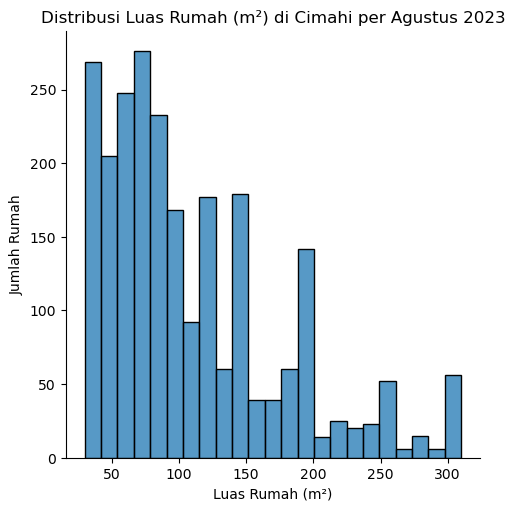

In [20]:
# Buang pencilan di Luas Rumah
outlier_area_index = iqr_outlier_removal(df_cimahi, 'Total Area')
non_outliers_area_cimahi = df_cimahi.drop(outlier_area_index)

# Lihat distribusi harga
sns.displot(data = non_outliers_area_cimahi,
            kind = 'hist',
            x = 'Total Area')
plt.title('Distribusi Luas Rumah (m²) di Cimahi per Agustus 2023')
plt.ylabel('Jumlah Rumah')
plt.xlabel('Luas Rumah (m²)')
plt.show()

Mayoritas luas rumah yang dijual di Cimahi memiliki luas 40 - 80 m²

In [21]:
# Mean, Min, Max berdasarkan kecamatan
luas_per_kecamatan_cimahi = df_cimahi.groupby(['Kecamatan'])['Total Area'].agg(['mean','min','max']).drop('LAINNYA').reset_index()
luas_per_kecamatan_cimahi = luas_per_kecamatan_cimahi.rename(columns = {'mean':'Rerata Luas (m²)',
                                                                       'min':'Minimum Luas (m²)',
                                                                       'max':'Maksimum Luas (m²)'})

# Visualisasikan
s = luas_per_kecamatan_cimahi.style.highlight_max(color='cornflowerblue').format(precision=0, thousands=".", decimal=",")

cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'background-color: #000066; font-style: bold; color: white; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #000066; color: white;'
}

s.set_table_styles([cell_hover, index_names, headers])

,Kecamatan,Rerata Luas (m²),Minimum Luas (m²),Maksimum Luas (m²)
0,CIMAHI SELATAN,178,30,6.846
1,CIMAHI TENGAH,157,30,2.000
2,CIMAHI UTARA,177,30,75.150


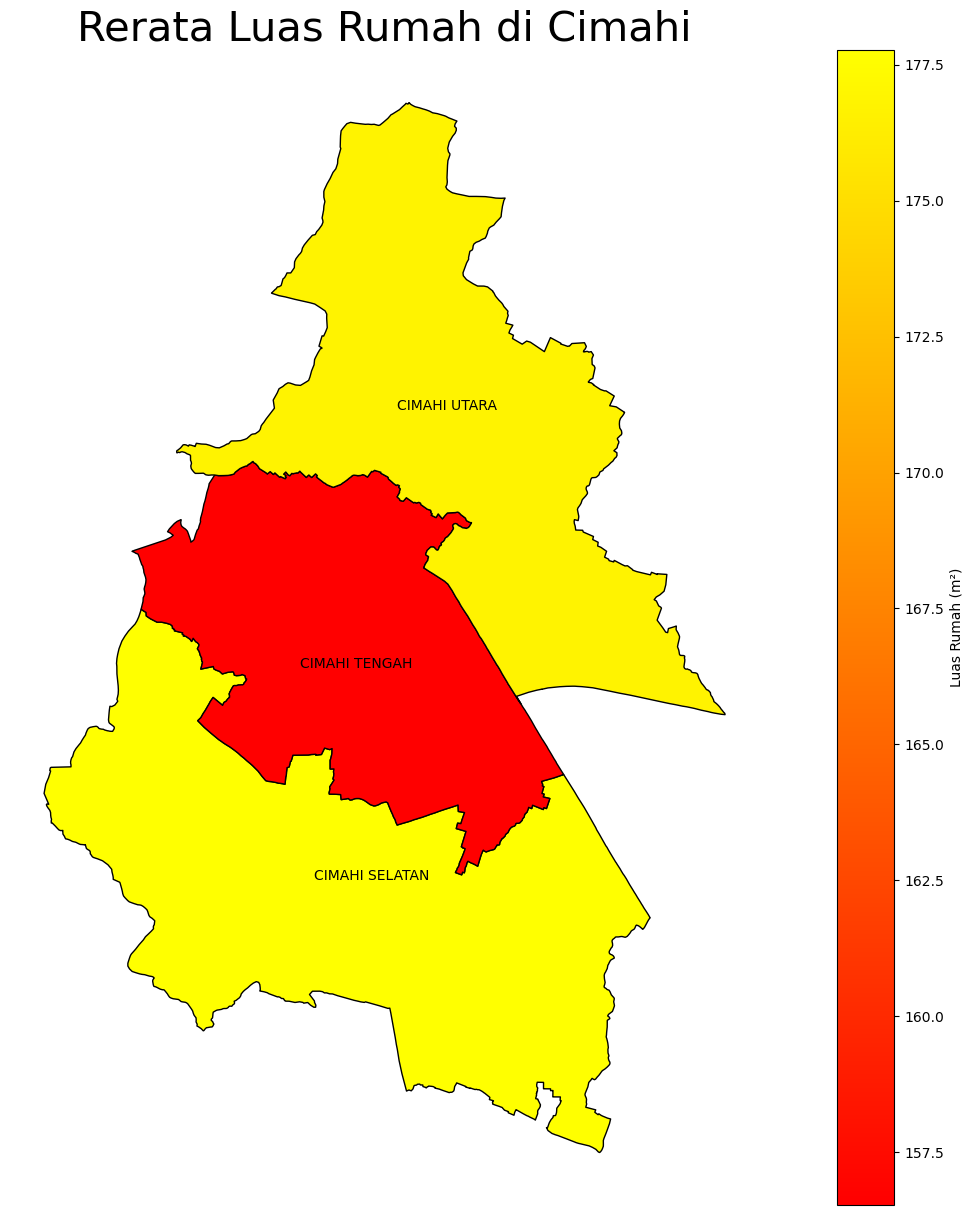

In [22]:
# Merge dengan luas rata-rata di Cimahi
cimahi_vis = cimahi.merge(luas_per_kecamatan_cimahi, left_on = 'KECAMATAN', right_on = 'Kecamatan', how = 'inner')
cimahi_vis.plot(column="Rerata Luas (m²)", 
                figsize = (20,15), 
                cmap="autumn", 
                edgecolor="k", 
                legend=True,
               legend_kwds={"label": "Luas Rumah (m²)"})
for idx, row in cimahi_vis.iterrows():
    plt.annotate(text=row['KECAMATAN'], xy=row['coords'], horizontalalignment='center')
plt.title('Rerata Luas Rumah di Cimahi', fontsize = 30)
plt.axis('off')
plt.show()

## Kota Bandung

### Harga Rumah di Kota Bandung

In [23]:
# Lihat Statistika Deskriptif berdasarkan Kota
df_bandung['Harga'].describe().to_frame()

,Harga
count,3.535100e+04
mean,8.967424e+09
std,2.255982e+11
min,1.100000e+06
25%,1.250000e+09
50%,2.350000e+09
75%,4.700000e+09
max,2.499000e+13


Dari informasi statistik di atas diperoleh:
* Rata-rata harga rumah di Kota Bandung mencapai Rp 5 M
* Harga minimum rumah yang dapat diperoleh di Kota Bandung adalah Rp 1.5 juta
* Harga maksimum rumah yang dapat diperoleh di Kota Bandung adalah Rp 495 M 

In [24]:
# Filter harga rumah minimum di Bandung
df_bandung[df_bandung['Harga'] == df_bandung['Harga'].min()]

,Nama,Lokasi,Harga,Jumlah Kamar Tidur,Jumlah Kamar Mandi,Total Area,Harga per Area,Jenis Properti,Sertifikat Rumah,Tanggal Posting,Nama Agen,Link,Provinsi,Kota,Kecamatan,Jalan
21991,Rumah Bandung Buah Batu,"Komplek Villa ilhami, Buahbatu, Bandung, Jawa ...",1100000.0,3,2.0,110,13253,Rumah,SHM - Sertifikat Hak Milik,2023-07-07 14:42:35.536679,Deden Widiana,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,BANDUNG,BUAHBATU,KOMPLEK VILLA ILHAMI


In [25]:
# Filter harga rumah maksimum di Bandung
df_bandung[df_bandung['Harga'] == df_bandung['Harga'].max()]

,Nama,Lokasi,Harga,Jumlah Kamar Tidur,Jumlah Kamar Mandi,Total Area,Harga per Area,Jenis Properti,Sertifikat Rumah,Tanggal Posting,Nama Agen,Link,Provinsi,Kota,Kecamatan,Jalan
15984,Jual rumah sayap Dago sultan tirtayasa,"Jalan sultan tirtayasa Dago bandung, Dago, Ban...",2.499000e+13,3,4.0,500,48057692308,Rumah,SHM - Sertifikat Hak Milik,2023-08-07 10:35:21.214173,Selva Eizallita,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,BANDUNG,COBLONG,JALAN SULTAN TIRTAYASA DAGO BANDUNG


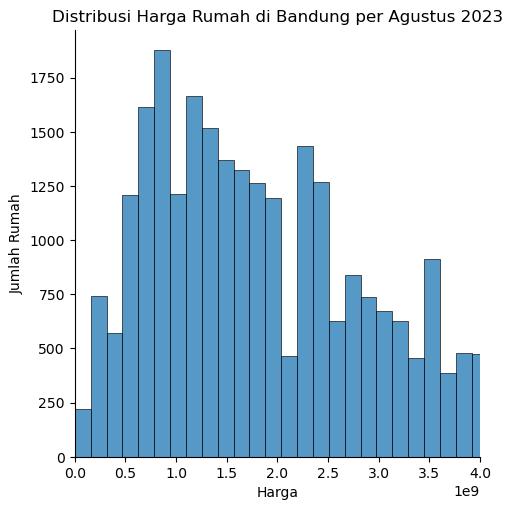

In [26]:
# Check outliers
outlier_index = iqr_outlier_removal(df_bandung, 'Harga')

# Remove outliers
non_outliers = df_bandung.drop(outlier_index)

# Lihat distribusi harga
sns.displot(data = non_outliers,
            kind = 'hist',
            x = 'Harga')
plt.title('Distribusi Harga Rumah di Bandung per Agustus 2023')
plt.xlim(0, 0.4e10)
plt.ylabel('Jumlah Rumah')
plt.show()

Sama halnya di Cimahi, mayoritas rumah yang dijual di Kota Bandung memiliki rentang harga 500 - 800 juta

### Harga Rumah per Kecamatan

In [27]:
# Mean, Min, Max berdasarkan kecamatan
harga_per_kecamatan_bdg = df_bandung.groupby(['Kecamatan'], as_index = False)['Harga'].agg(['count', 'mean','min','max']).reset_index()
harga_per_kecamatan_bdg = harga_per_kecamatan_bdg.rename(columns = {'count':'Jumlah Rumah',
                                                                         'mean':'Rerata Harga (Rp)',
                                                                         'min':'Harga minimum (Rp)',
                                                                         'max':'Harga maksimum (Rp)'})

# Buat Tampilan yang lebih cantik
s = harga_per_kecamatan_bdg.style.highlight_max(color='pink').format(precision=0, thousands=".", decimal=",")

cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'background-color: #000066; font-style: bold; color: white; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #000066; color: white;'
}

s.set_table_styles([cell_hover, index_names, headers])

,Kecamatan,Jumlah Rumah,Rerata Harga (Rp),Harga minimum (Rp),Harga maksimum (Rp)
0,ANDIR,383,3.271.076.849,1.800.000,32.166.000.000
1,ANTAPANI,2.551,3.012.913.474,3.800.000,2.500.000.000.000
2,ARCAMANIK,2.275,3.794.467.959,3.500.000,2.750.000.000.000
3,ASTANAANYAR,324,3.456.303.885,100.000.000,35.000.000.000
4,BABAKAN CIPARAY,305,3.233.865.863,45.000.000,17.500.000.000
5,BANDUNG KIDUL,229,5.035.184.525,26.000.000,39.000.000.000
6,BANDUNG KULON,1.040,2.124.006.102,55.000.000,33.000.000.000
7,BANDUNG WETAN,945,17.906.150.585,8.250.000,130.000.000.000
8,BATUNUNGGAL,1.379,14.606.017.244,43.000.000,14.000.000.000.000
9,BOJONGLOA KALER,1.856,1.662.032.609,10.000.000,45.500.000.000


Dari informasi statistik di atas diperoleh:
* Kecamatan Buahbatu memiliki penjualan rumah tertinggi
* Kecamatan Cicendo memiliki rerata harga rumah tertinggi 

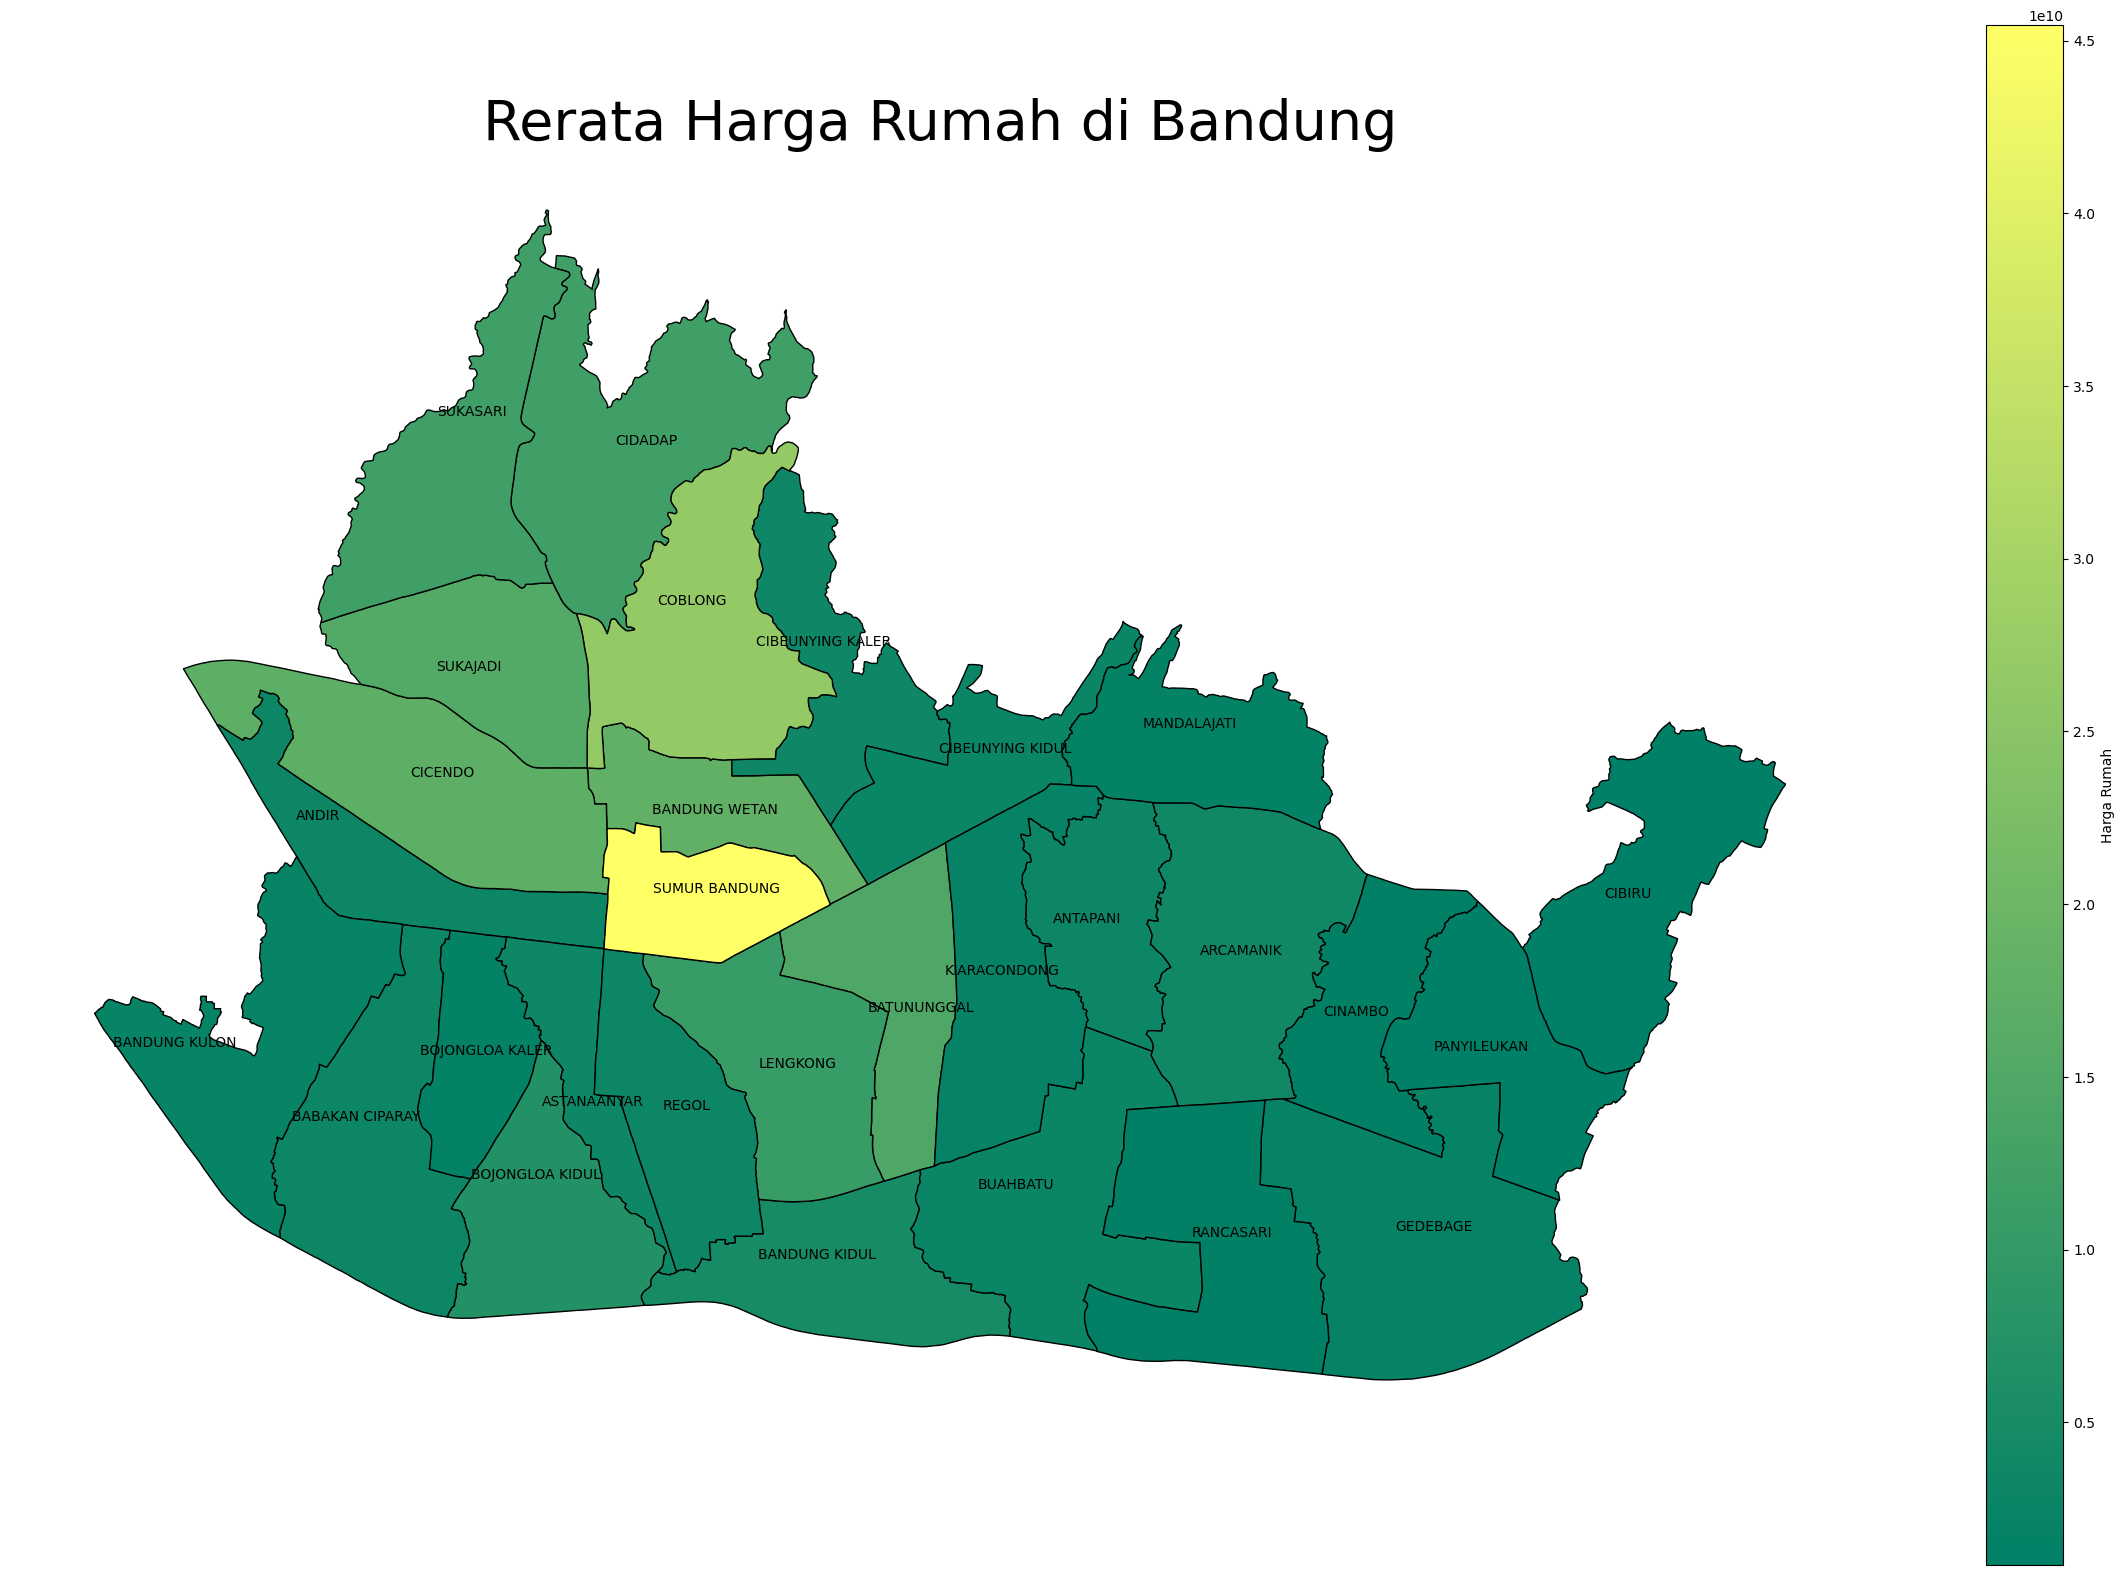

In [28]:
# Merge dengan harga rata-rata di Bandung
bandung_vis = bandung.merge(harga_per_kecamatan_bdg, left_on = 'KECAMATAN', right_on = 'Kecamatan', how = 'inner')

# Visualize rerata harga rumah
bandung_vis.plot(column="Rerata Harga (Rp)", 
                figsize = (30,20), 
                cmap="summer", 
                edgecolor="k", 
                legend=True,
               legend_kwds={"label": "Harga Rumah"})
for idx, row in bandung_vis.iterrows():
    plt.annotate(text=row['KECAMATAN'], 
                 xy=row['coords'], 
                 xytext = row['coords'],
                 horizontalalignment='center')
plt.title('Rerata Harga Rumah di Bandung', fontsize = 40)
plt.axis('off')
plt.show()

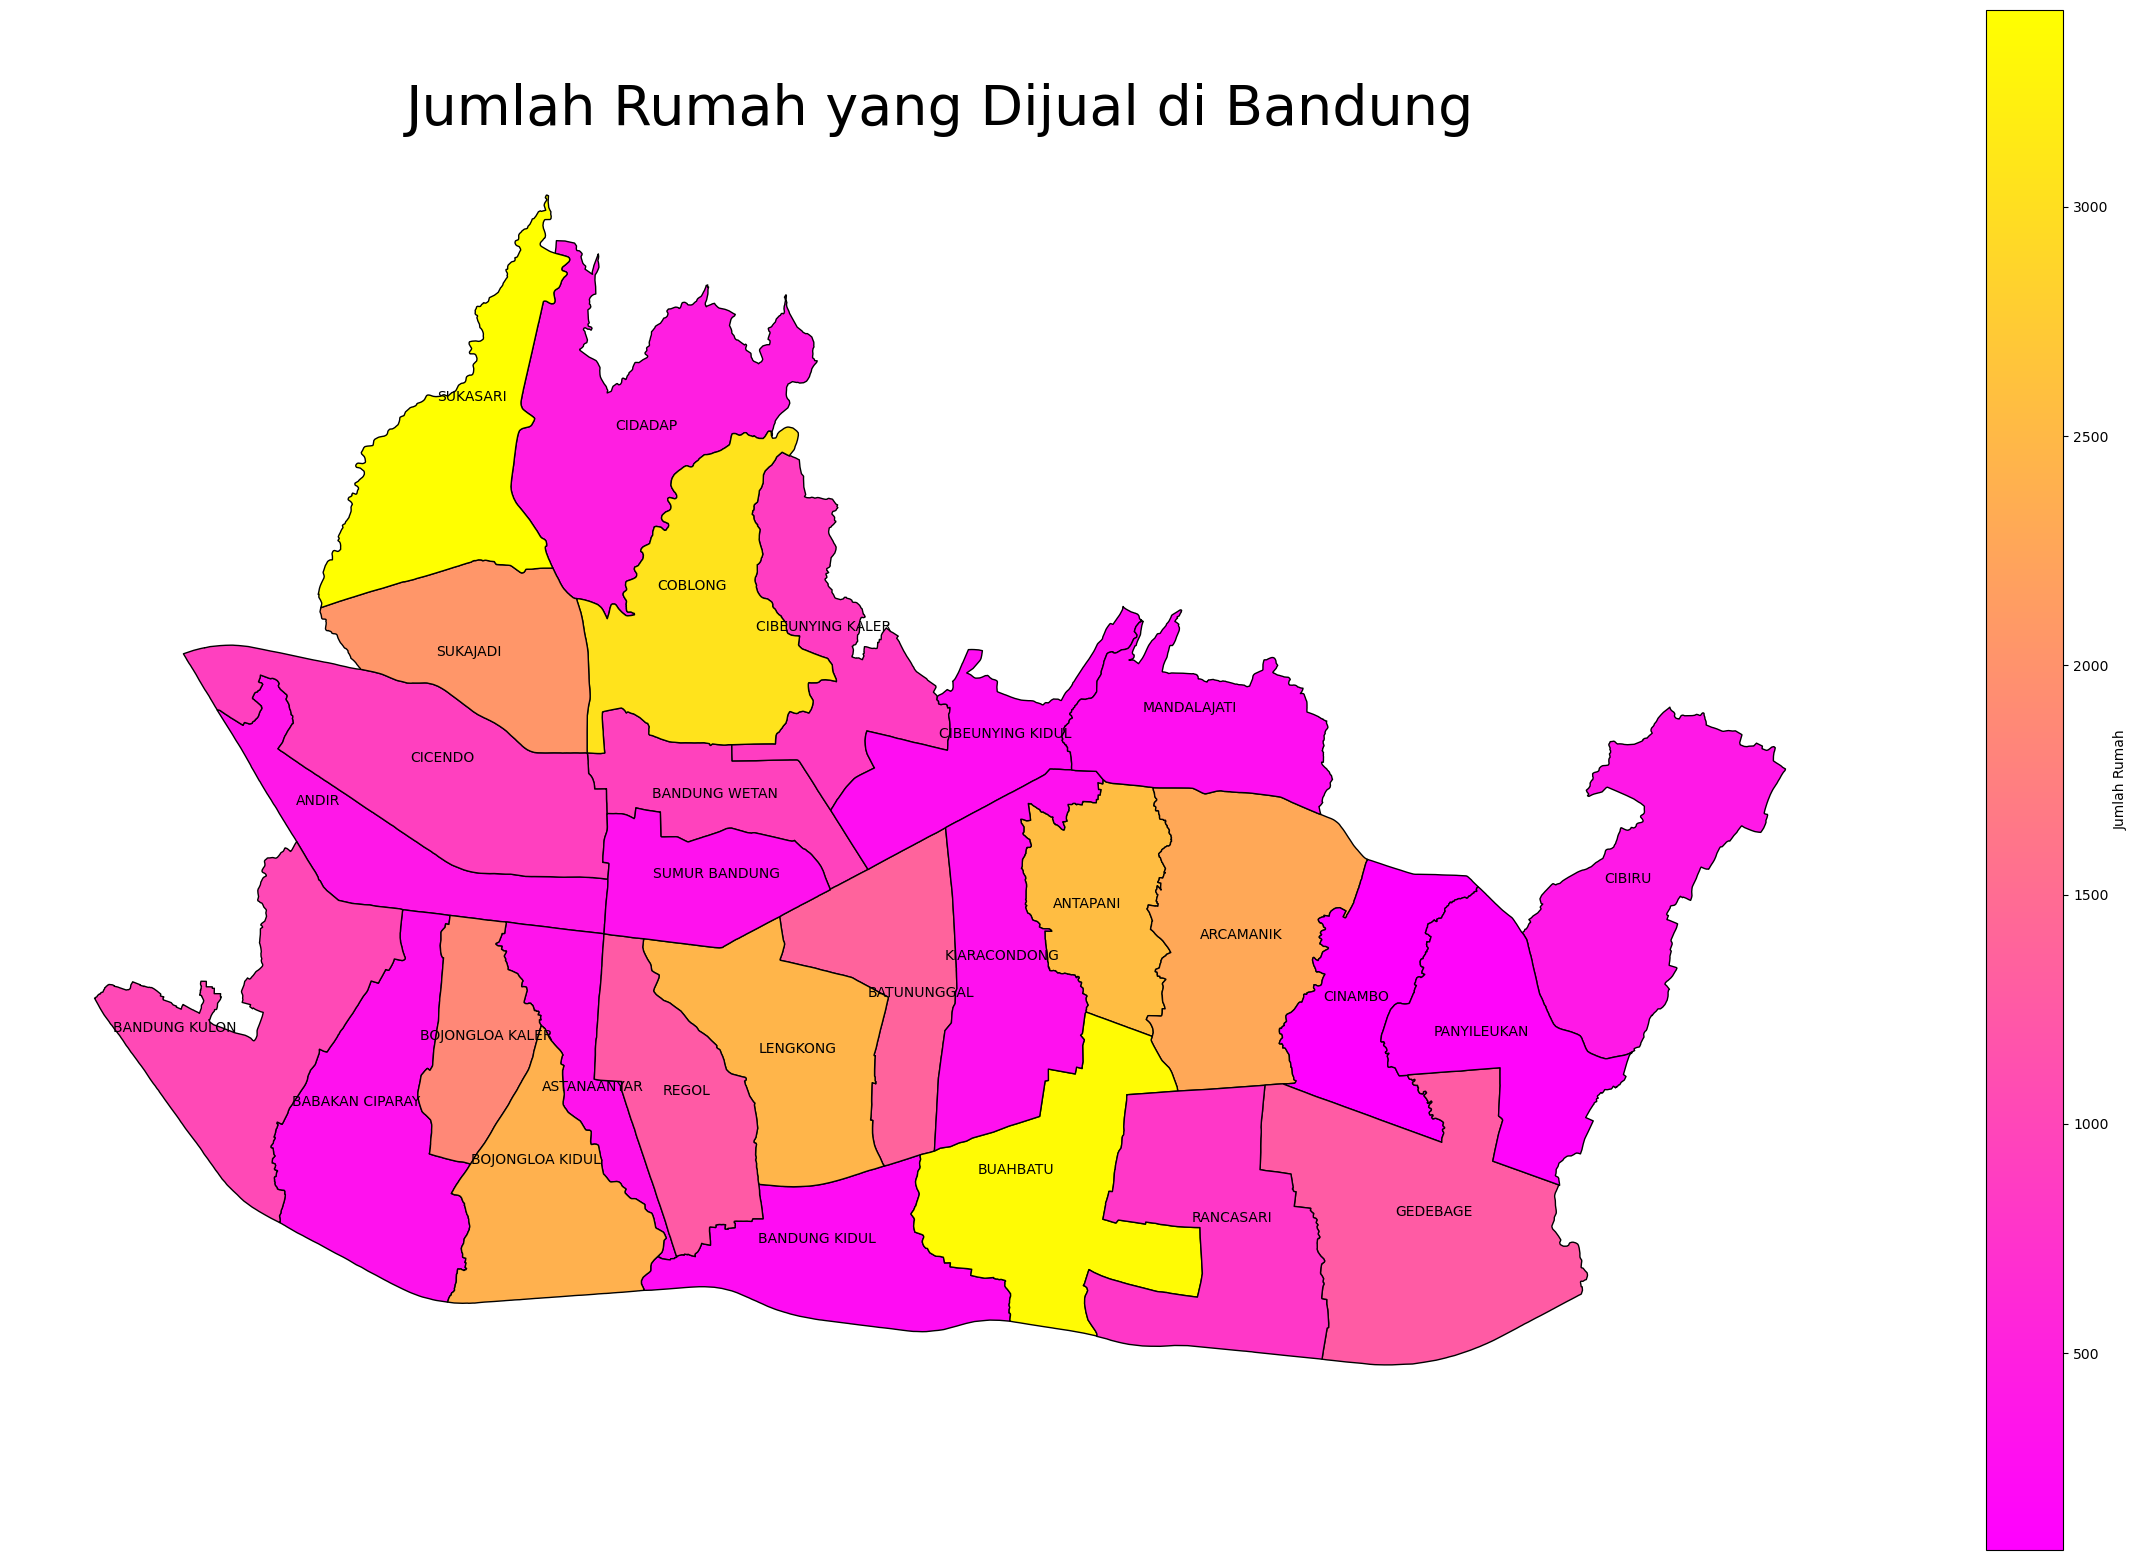

In [29]:
# Visualize jumlah rumah
bandung_vis.plot(column="Jumlah Rumah", 
                figsize = (30,20), 
                cmap="spring", 
                edgecolor="k", 
                legend=True,
               legend_kwds={"label": "Jumlah Rumah"})
for idx, row in bandung_vis.iterrows():
    plt.annotate(text=row['KECAMATAN'], 
                 xy=row['coords'], 
                 xytext = row['coords'],
                 horizontalalignment='center')
plt.title('Jumlah Rumah yang Dijual di Bandung', fontsize = 40)
plt.axis('off')
plt.show()

### Luas Bangunan di Kota Bandung

In [30]:
# Lihat Statistika Deskriptif berdasarkan Luas Rumah
df_bandung['Total Area'].describe().to_frame()

,Total Area
count,35351.000000
mean,251.598993
std,273.037982
min,1.000000
25%,100.000000
50%,180.000000
75%,300.000000
max,10000.000000


Dari informasi statistik di atas diperoleh:
* Luas rumah rata2 di Kota Bandung adalah 249 m²
* Luas rumah minimum di Kota Bandung adalah 1 m²
* Luas rumah maksimum di Kota Bandung adalah 10000 m²

In [31]:
# Filter luas rumah minimum di Bandung
df_bandung[df_bandung['Total Area'] == df_bandung['Total Area'].min()]

,Nama,Lokasi,Harga,Jumlah Kamar Tidur,Jumlah Kamar Mandi,Total Area,Harga per Area,Jenis Properti,Sertifikat Rumah,Tanggal Posting,Nama Agen,Link,Provinsi,Kota,Kecamatan,Jalan
175,Dijual Rumah Pinggir Jalan Harga Hitung Tanah ...,"Turangga, Bandung, Jawa Barat",3.591000e+09,1,1.0,1,13500000,Rumah,SHM - Sertifikat Hak Milik,2023-07-31 07:12:01.657874,Rosie .,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,BANDUNG,LENGKONG,TURANGGA
715,SISA 1 KAVLING TANAH RECCOMENDED DI KEMBAR BKR...,"SAYAP BKR, Buahbatu, Bandung, Jawa Barat",1.220000e+09,Studio,NaN,1,10000000,Rumah,SHM - Sertifikat Hak Milik,2023-08-02 22:35:25.704882,Rexsi Nugraha,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,BANDUNG,BUAHBATU,SAYAP BKR
3279,Rumah Belanda Terawat Hitung Tanah di Sayap Riau,"Jalan Riau (Martadinata, RE), Bandung Wetan, B...",8.740000e+09,4,2.0,1,20000000,Rumah,SHM - Sertifikat Hak Milik,2023-07-31 09:48:19.977183,Fonita .,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,BANDUNG,BANDUNG WETAN,JALAN RIAU (MARTADINATA
3612,Di jual Rumah Strategis Jl. Banteng Pelajar Pe...,"Jl. Banteng, Buahbatu, Bandung, Jawa Barat",8.500000e+09,5,3.0,1,14003295,Rumah,SHM - Sertifikat Hak Milik,2023-07-31 10:01:36.020366,Herwan Dhani Pandi,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,BANDUNG,BUAHBATU,JL. BANTENG
4449,Summarecon Bandung,"Rancabolang, Gedebage, Kota Bandung, Jawa Bara...",3.391000e+09,Studio,NaN,1,11534014,Rumah,SHGB - Hak Guna Bangunan,2023-07-29 10:36:19.448804,Michael Poyo,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,BANDUNG,GEDEBAGE,RANCABOLANG
10729,Sayap Riau,"Flores, Bandung Wetan, Bandung, Jawa Barat",2.400000e+07,Studio,NaN,1,29740,Rumah,SHM - Sertifikat Hak Milik,2023-08-04 16:33:35.585479,Aldo Jaya,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,BANDUNG,BANDUNG WETAN,FLORES
14590,Rumah Tua Hitung Tanah di Bandung,"tera, Sumur Bandung, Bandung, Jawa Barat",3.300000e+09,1,1.0,1,16097561,Rumah,SHM - Sertifikat Hak Milik,2023-08-07 09:38:35.729941,Marlina Sambas,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,BANDUNG,SUMUR BANDUNG,TERA
16622,Resor Dago Pakar,"Jl. Raya Golf Dago, Dago, Bandung, Coblong, Ba...",5.500000e+06,1,NaN,1,18212,Rumah,SHM - Sertifikat Hak Milik,2023-08-07 10:50:06.419719,Vay .,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,BANDUNG,COBLONG,JL. RAYA GOLF DAGO
18995,Rumah Riau Tengah Kota Bandung Bisa untuk Usaha,"Riau Re Martadinata, Bandung, Jawa Barat",1.450000e+10,1,1.0,1,36523929,Rumah,SHM - Sertifikat Hak Milik,2023-07-07 12:49:11.005343,Renaldo Giovanni,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,BANDUNG,BANDUNG WETAN,RIAU RE MARTADINATA
22027,Pratista Taman Sakura,"Jl. Terusan Pasirkoja, Bandung, Astanaanyar, B...",1.229200e+10,Studio,NaN,1,14000000,Rumah,SHM - Sertifikat Hak Milik,2023-07-07 14:43:46.486774,Michael Poyo,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,BANDUNG,ASTANAANYAR,JL. TERUSAN PASIRKOJA


Ada Rumah dengan 4 kamar tidur, 3 kamar mandi tetapi luas rumahnya 1 m², ini sangat aneh

In [32]:
# Filter luas rumah maksimum di Bandung
df_bandung[df_bandung['Total Area'] == df_bandung['Total Area'].max()]

,Nama,Lokasi,Harga,Jumlah Kamar Tidur,Jumlah Kamar Mandi,Total Area,Harga per Area,Jenis Properti,Sertifikat Rumah,Tanggal Posting,Nama Agen,Link,Provinsi,Kota,Kecamatan,Jalan
985,jl cipaku,"jl cipaku, Setiabudi, Bandung, Jawa Barat",1.800000e+10,3,2.0,10000,25714286,Rumah,SHM - Sertifikat Hak Milik,2023-08-02 16:46:53.923817,Lili Solihin,https://www.rumah.com/listing-properti/dijual-...,JAWA BARAT,BANDUNG,SUKASARI,JL CIPAKU


Rumah dengan luas bangunan terbesar ada di Setiabudi dengan harga Rp 18 M, 3 kamar tidur, dan 2 kamar mandi

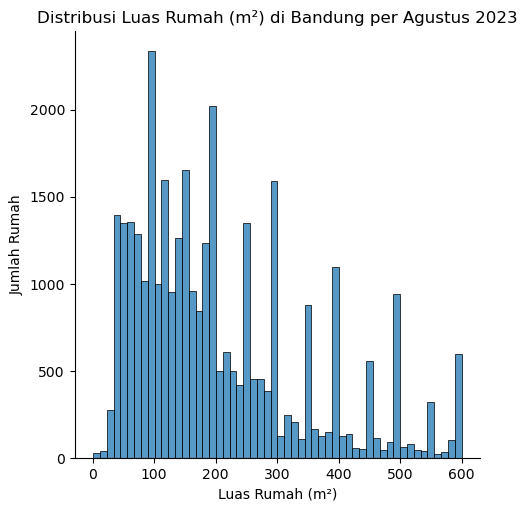

In [33]:
# Buang pencilan di Luas Rumah
outlier_area_index = iqr_outlier_removal(df_bandung, 'Total Area')
non_outliers_area = df_bandung.drop(outlier_area_index)

# Lihat distribusi Luas Bangunan Rumah di Bandung
sns.displot(data = non_outliers_area,
            kind = 'hist',
            x = 'Total Area')
plt.title('Distribusi Luas Rumah (m²) di Bandung per Agustus 2023')
plt.ylabel('Jumlah Rumah')
plt.xlabel('Luas Rumah (m²)')
plt.show()

Mayoritas rumah yang dijual di Kota Bandung memiliki luas rumah 130 - 150 m²

### Luas Rumah per Kecamatan

In [34]:
# Mean, Min, Max berdasarkan kecamatan
luas_per_kecamatan_bdg = df_bandung.groupby(['Kecamatan'], as_index = False)['Total Area'].agg(['mean','min','max']).reset_index()
luas_per_kecamatan_bdg = luas_per_kecamatan_bdg.rename(columns = {'mean':'Rerata Luas (m²)',
                                                                       'min':'Minimum Luas (m²)',
                                                                       'max':'Maksimum Luas (m²)'})

# Visualisasikan
s = luas_per_kecamatan_bdg.style.highlight_max(color='cornflowerblue').format(precision=0, thousands=".", decimal=",")

cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'background-color: #000066; font-style: bold; color: white; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #000066; color: white;'
}

s.set_table_styles([cell_hover, index_names, headers])

,Kecamatan,Rerata Luas (m²),Minimum Luas (m²),Maksimum Luas (m²)
0,ANDIR,243,21,3.000
1,ANTAPANI,137,9,1.500
2,ARCAMANIK,129,21,7.575
3,ASTANAANYAR,237,1,900
4,BABAKAN CIPARAY,244,21,1.600
5,BANDUNG KIDUL,321,30,1.700
6,BANDUNG KULON,179,21,5.000
7,BANDUNG WETAN,431,1,3.000
8,BATUNUNGGAL,281,30,1.700
9,BOJONGLOA KALER,165,10,5.500


Dari informasi statistik di atas diperoleh:
* Rerata luas bangunan tertinggi ada di Kecamatan Cidadap
* Terdapat rumah dengan luas maksimum 10000 m² di Kecamatan Sukasari

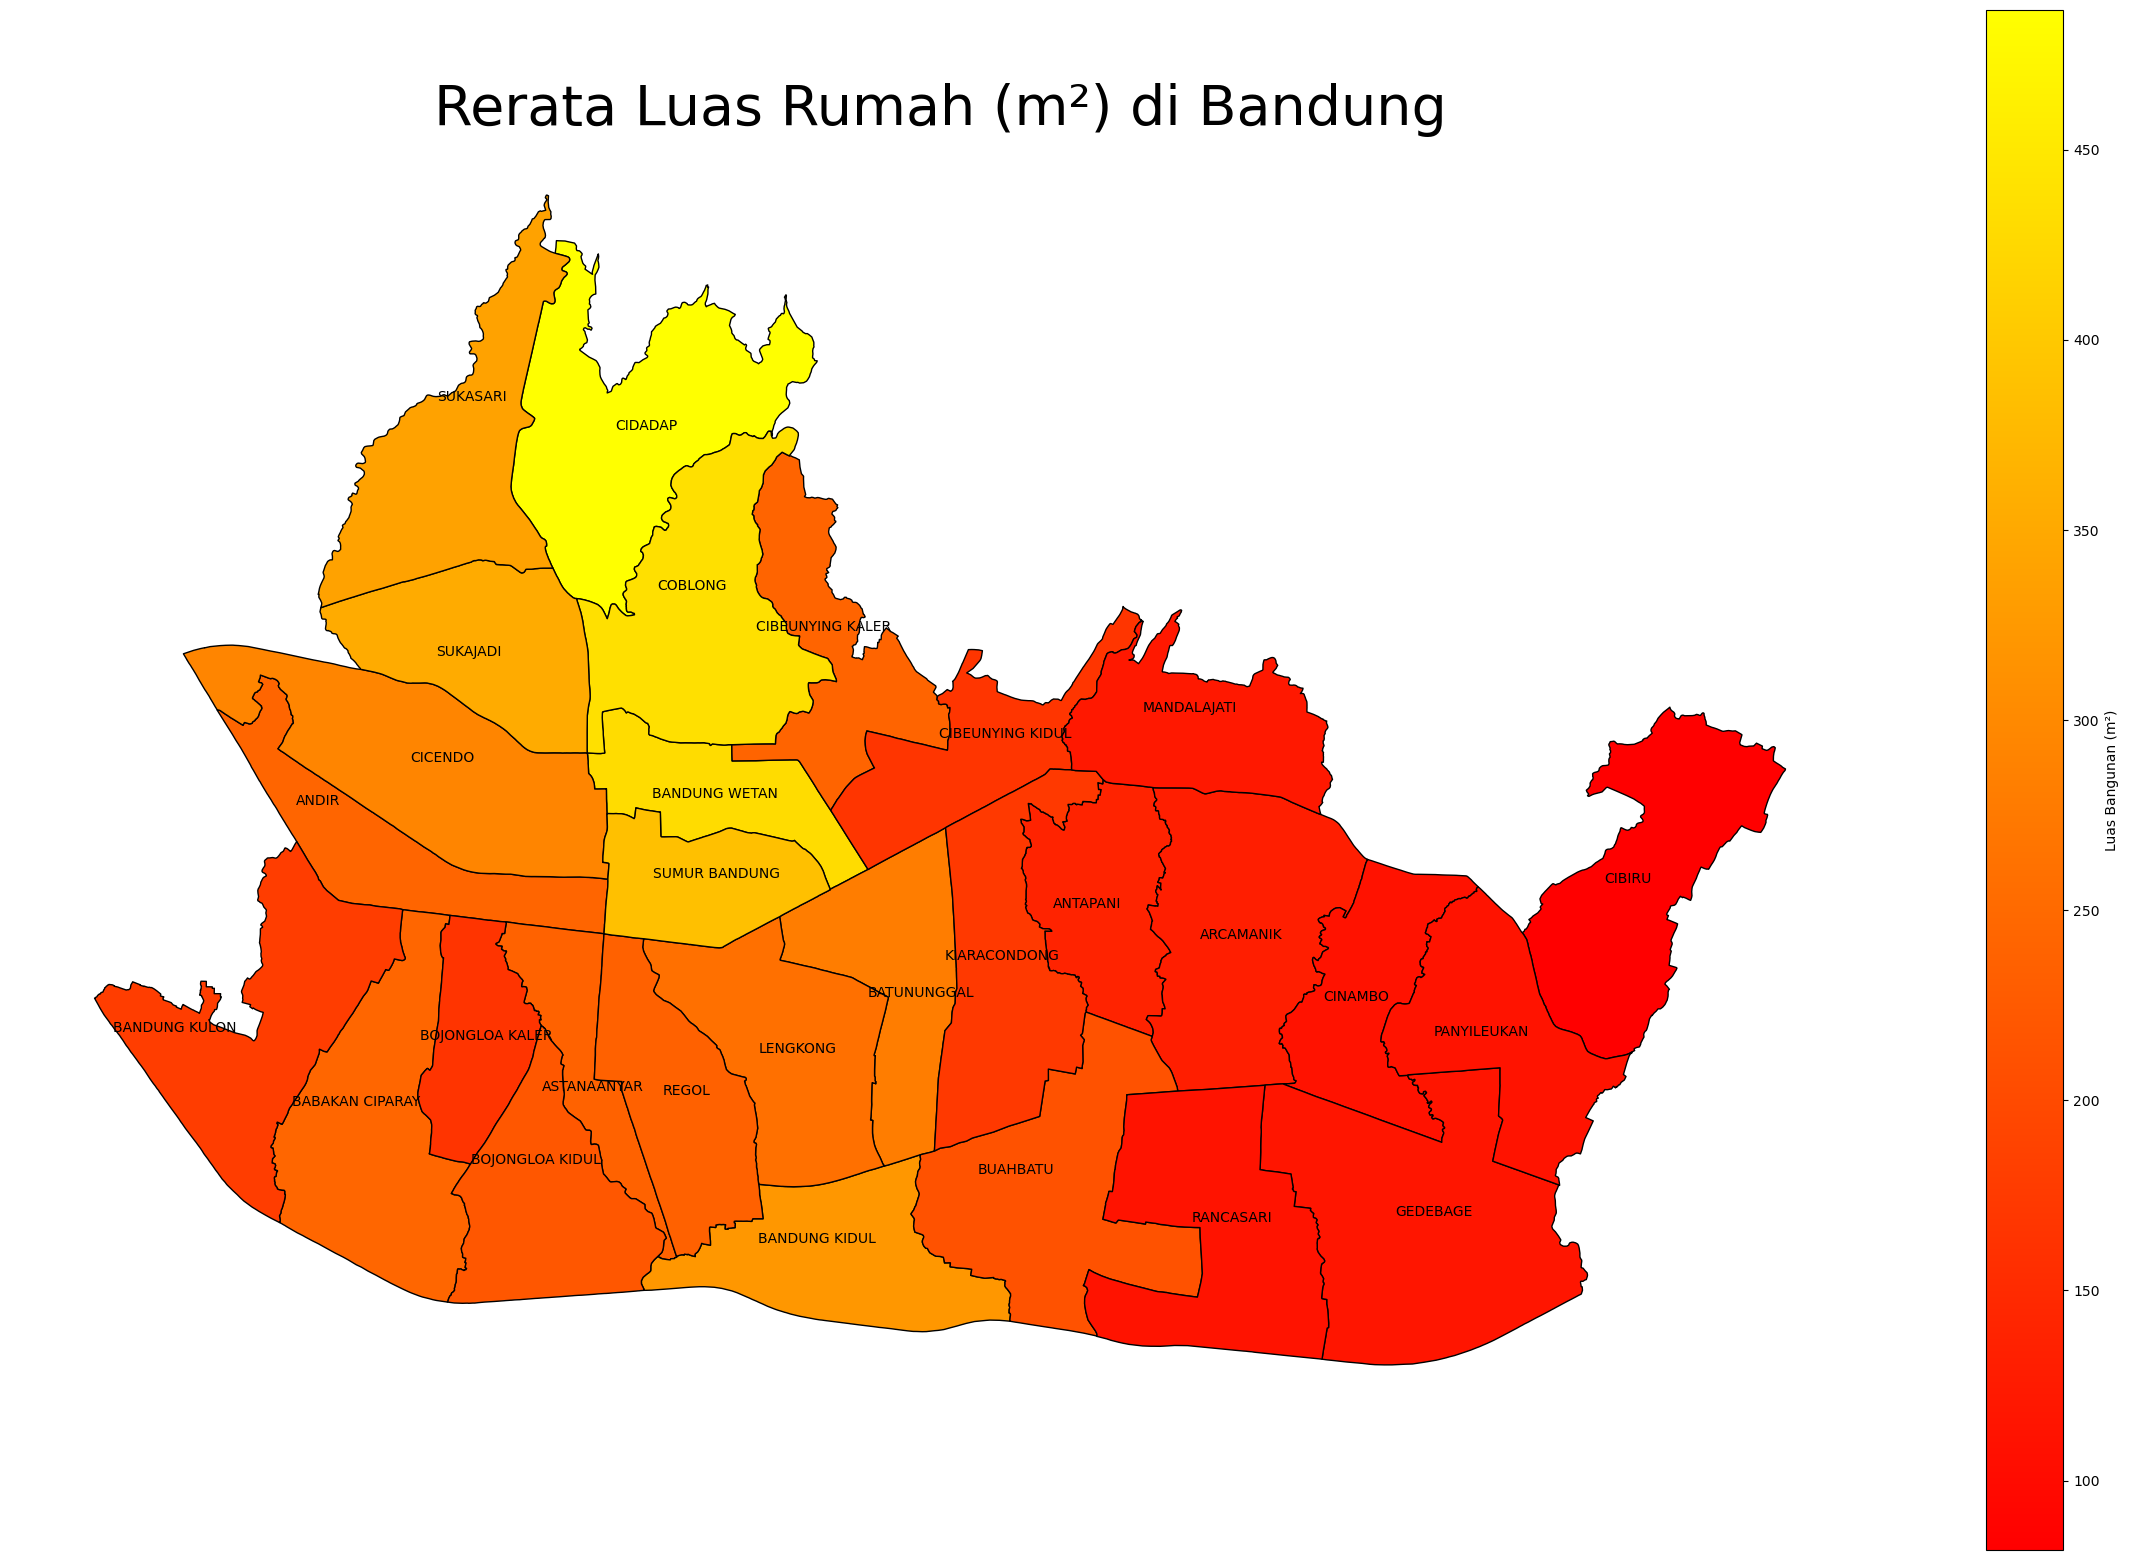

In [35]:
# Merge dengan luas rata-rata di Cimahi
bandung_vis = bandung.merge(luas_per_kecamatan_bdg, left_on = 'KECAMATAN', right_on = 'Kecamatan', how = 'inner')
bandung_vis.plot(column="Rerata Luas (m²)", 
                figsize = (30, 20), 
                cmap="autumn", 
                edgecolor="k", 
                legend=True,
               legend_kwds={"label": "Luas Bangunan (m²)"})
for idx, row in bandung_vis.iterrows():
    plt.annotate(text=row['KECAMATAN'], xy=row['coords'], horizontalalignment='center')
plt.title('Rerata Luas Rumah (m²) di Bandung', fontsize = 40)
plt.axis('off')
plt.show()

## Komparasi antara Cimahi dan Bandung

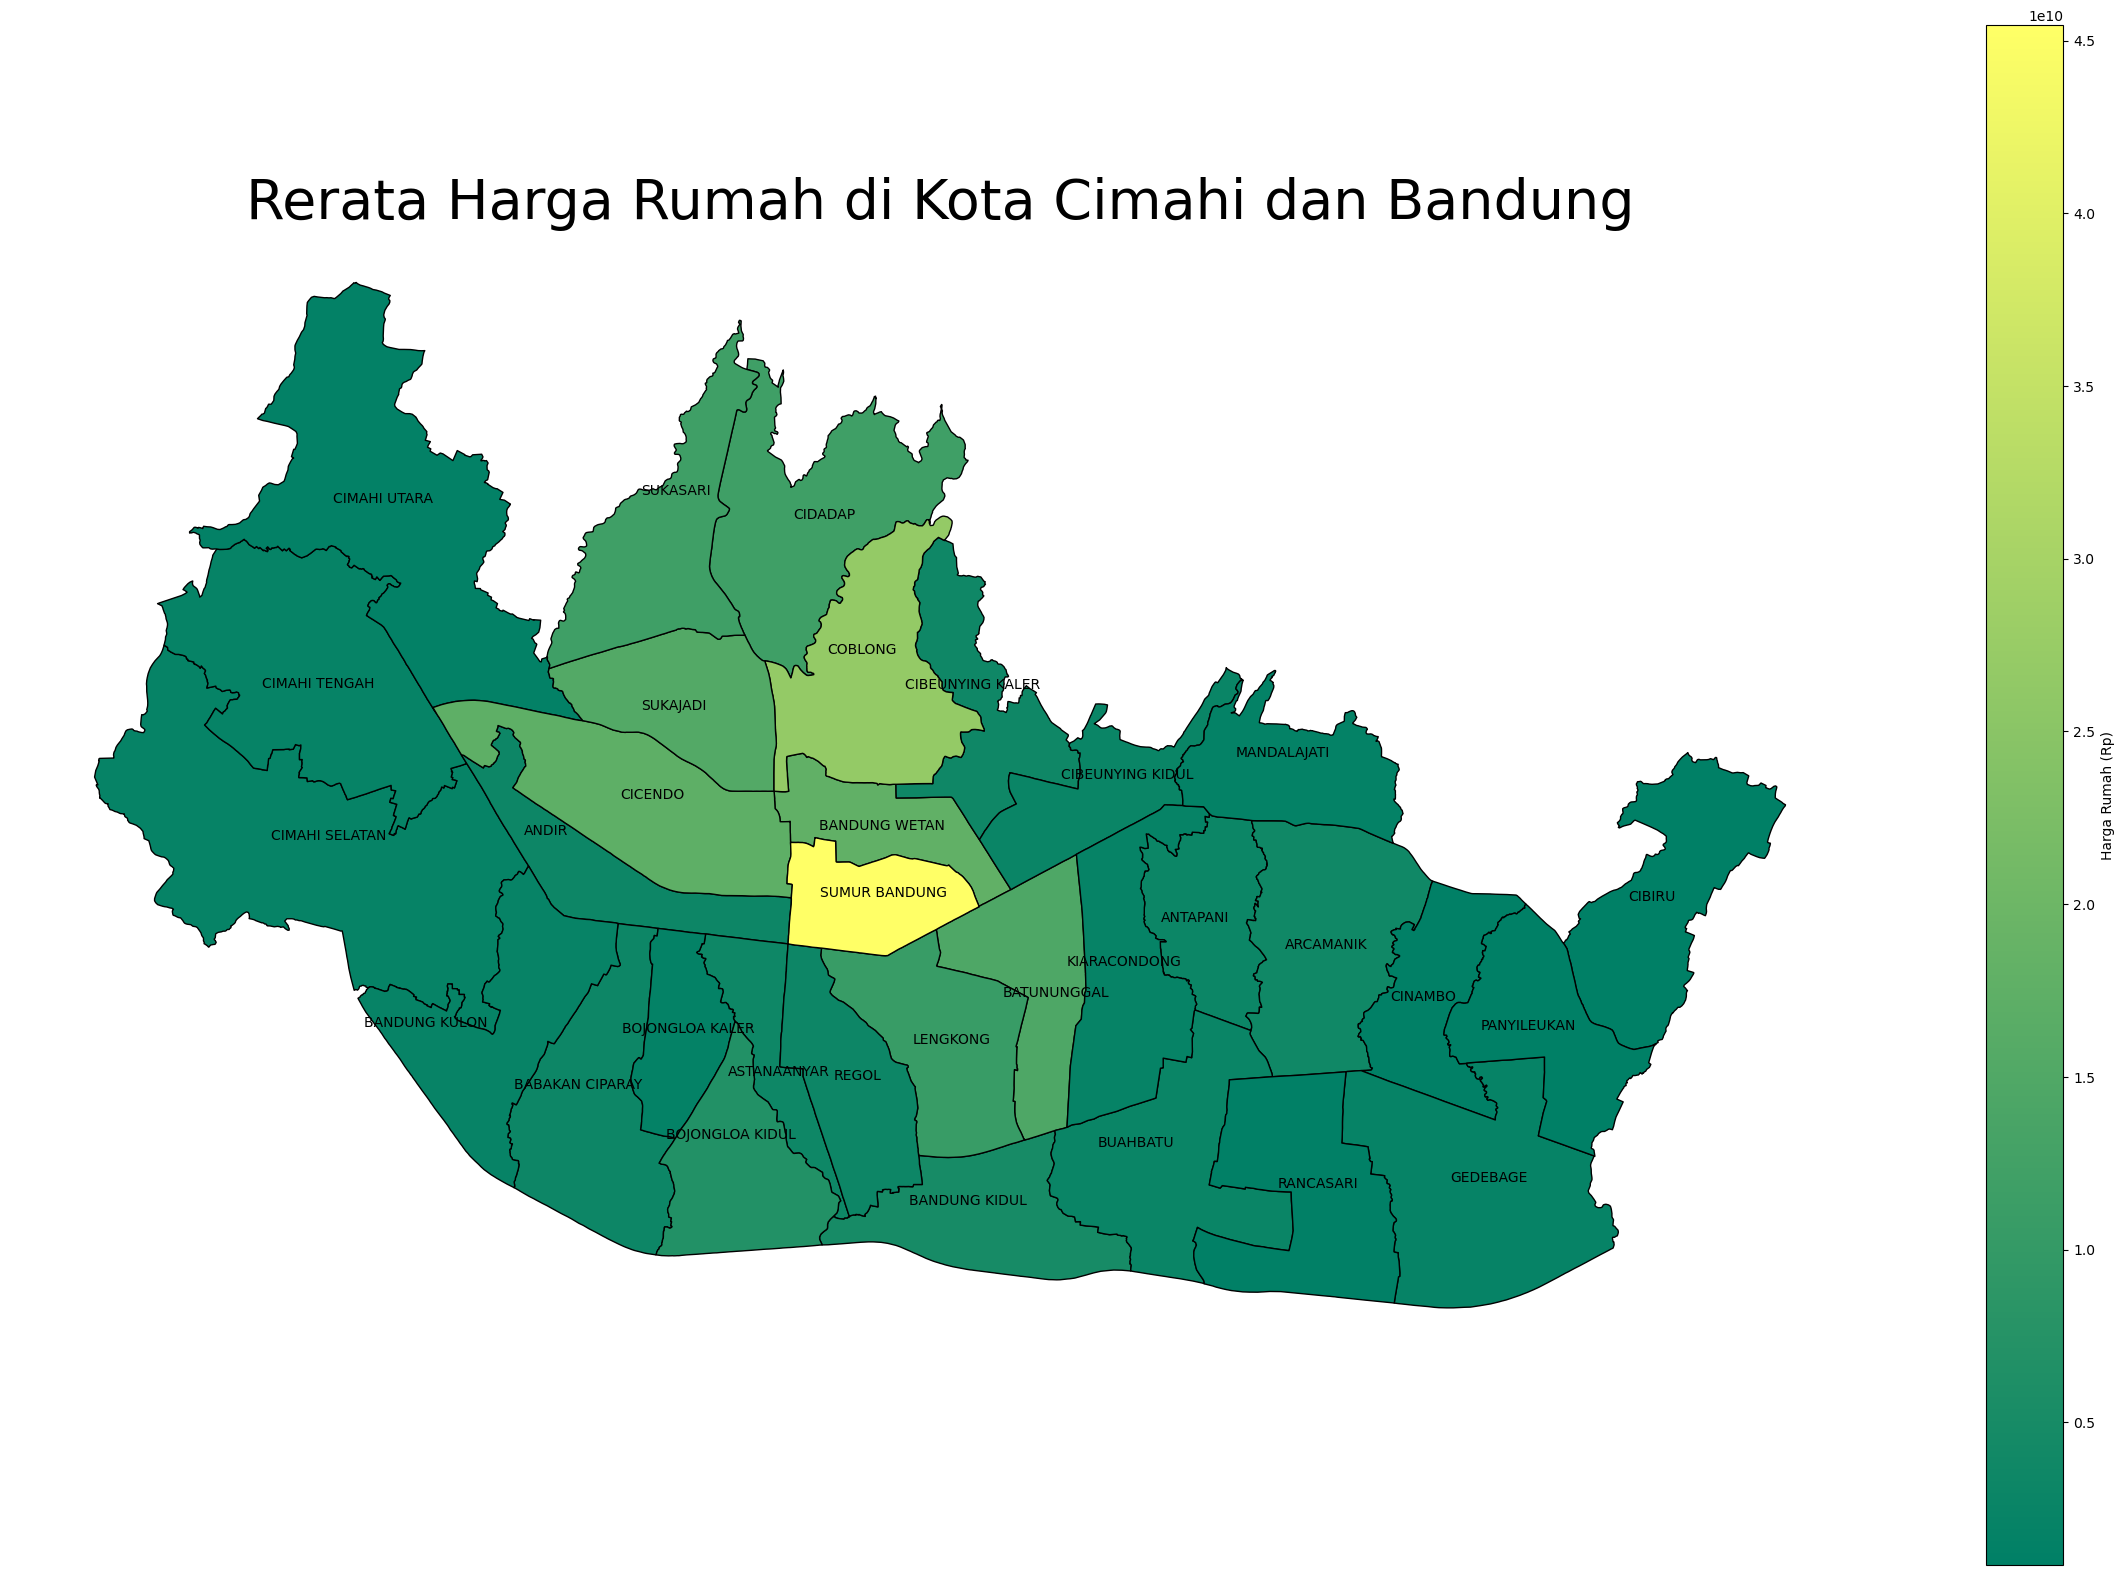

In [36]:
# Merge data
cimahi_vis = cimahi.merge(harga_per_kecamatan_cimahi, left_on = 'KECAMATAN', right_on = 'Kecamatan', how = 'inner')
bandung_vis = bandung.merge(harga_per_kecamatan_bdg, left_on = 'KECAMATAN', right_on = 'Kecamatan', how = 'inner')
vis = pd.concat([cimahi_vis, bandung_vis], axis = 0, ignore_index = True)

# Plot Rerata Harga
vis.plot(column="Rerata Harga (Rp)", 
         figsize = (30, 20), 
         cmap="summer", 
         edgecolor="k", 
         legend=True,
         legend_kwds={"label": "Harga Rumah (Rp)"})
for idx, row in vis.iterrows():
    plt.annotate(text=row['KECAMATAN'], xy=row['coords'], horizontalalignment='center')
plt.title('Rerata Harga Rumah di Kota Cimahi dan Bandung',fontsize = 40)
plt.axis('off')
plt.show()

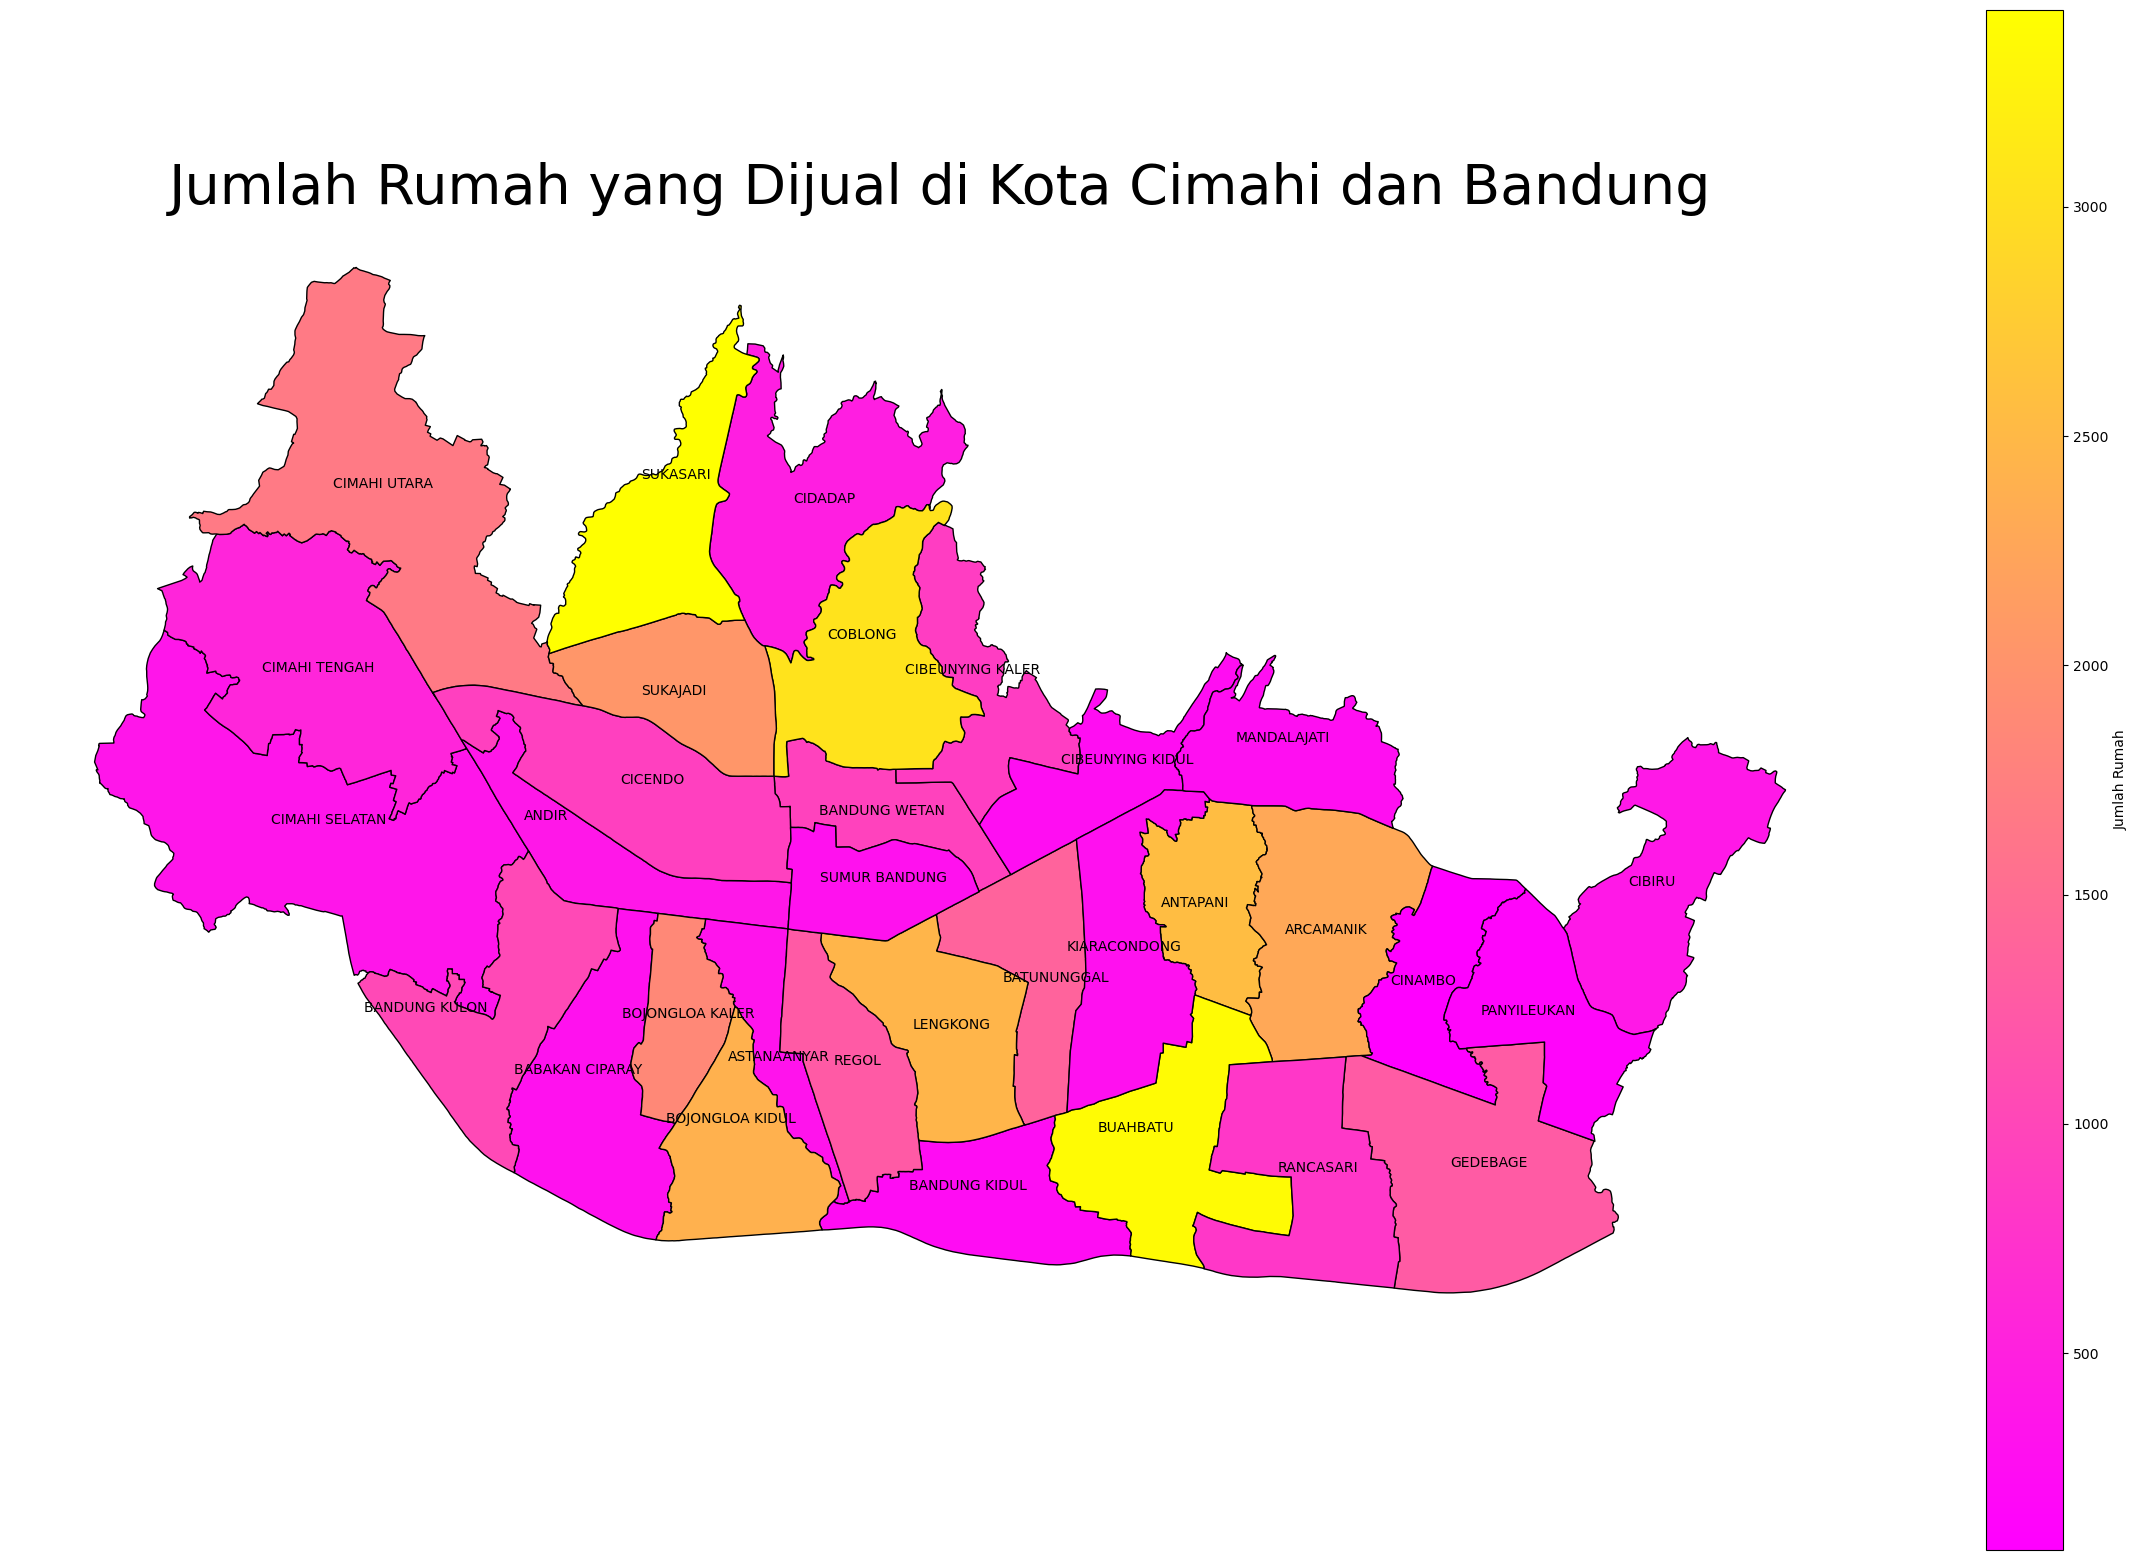

In [37]:
# Plot Jumlah Rumah
vis.plot(column="Jumlah Rumah", 
         figsize = (30,20), 
         cmap="spring", 
         edgecolor="k", 
         legend=True,
         legend_kwds={"label": "Jumlah Rumah"})
for idx, row in vis.iterrows():
    plt.annotate(text=row['KECAMATAN'], xy=row['coords'], horizontalalignment='center')
plt.title('Jumlah Rumah yang Dijual di Kota Cimahi dan Bandung', fontsize = 40)
plt.axis('off')
plt.show()

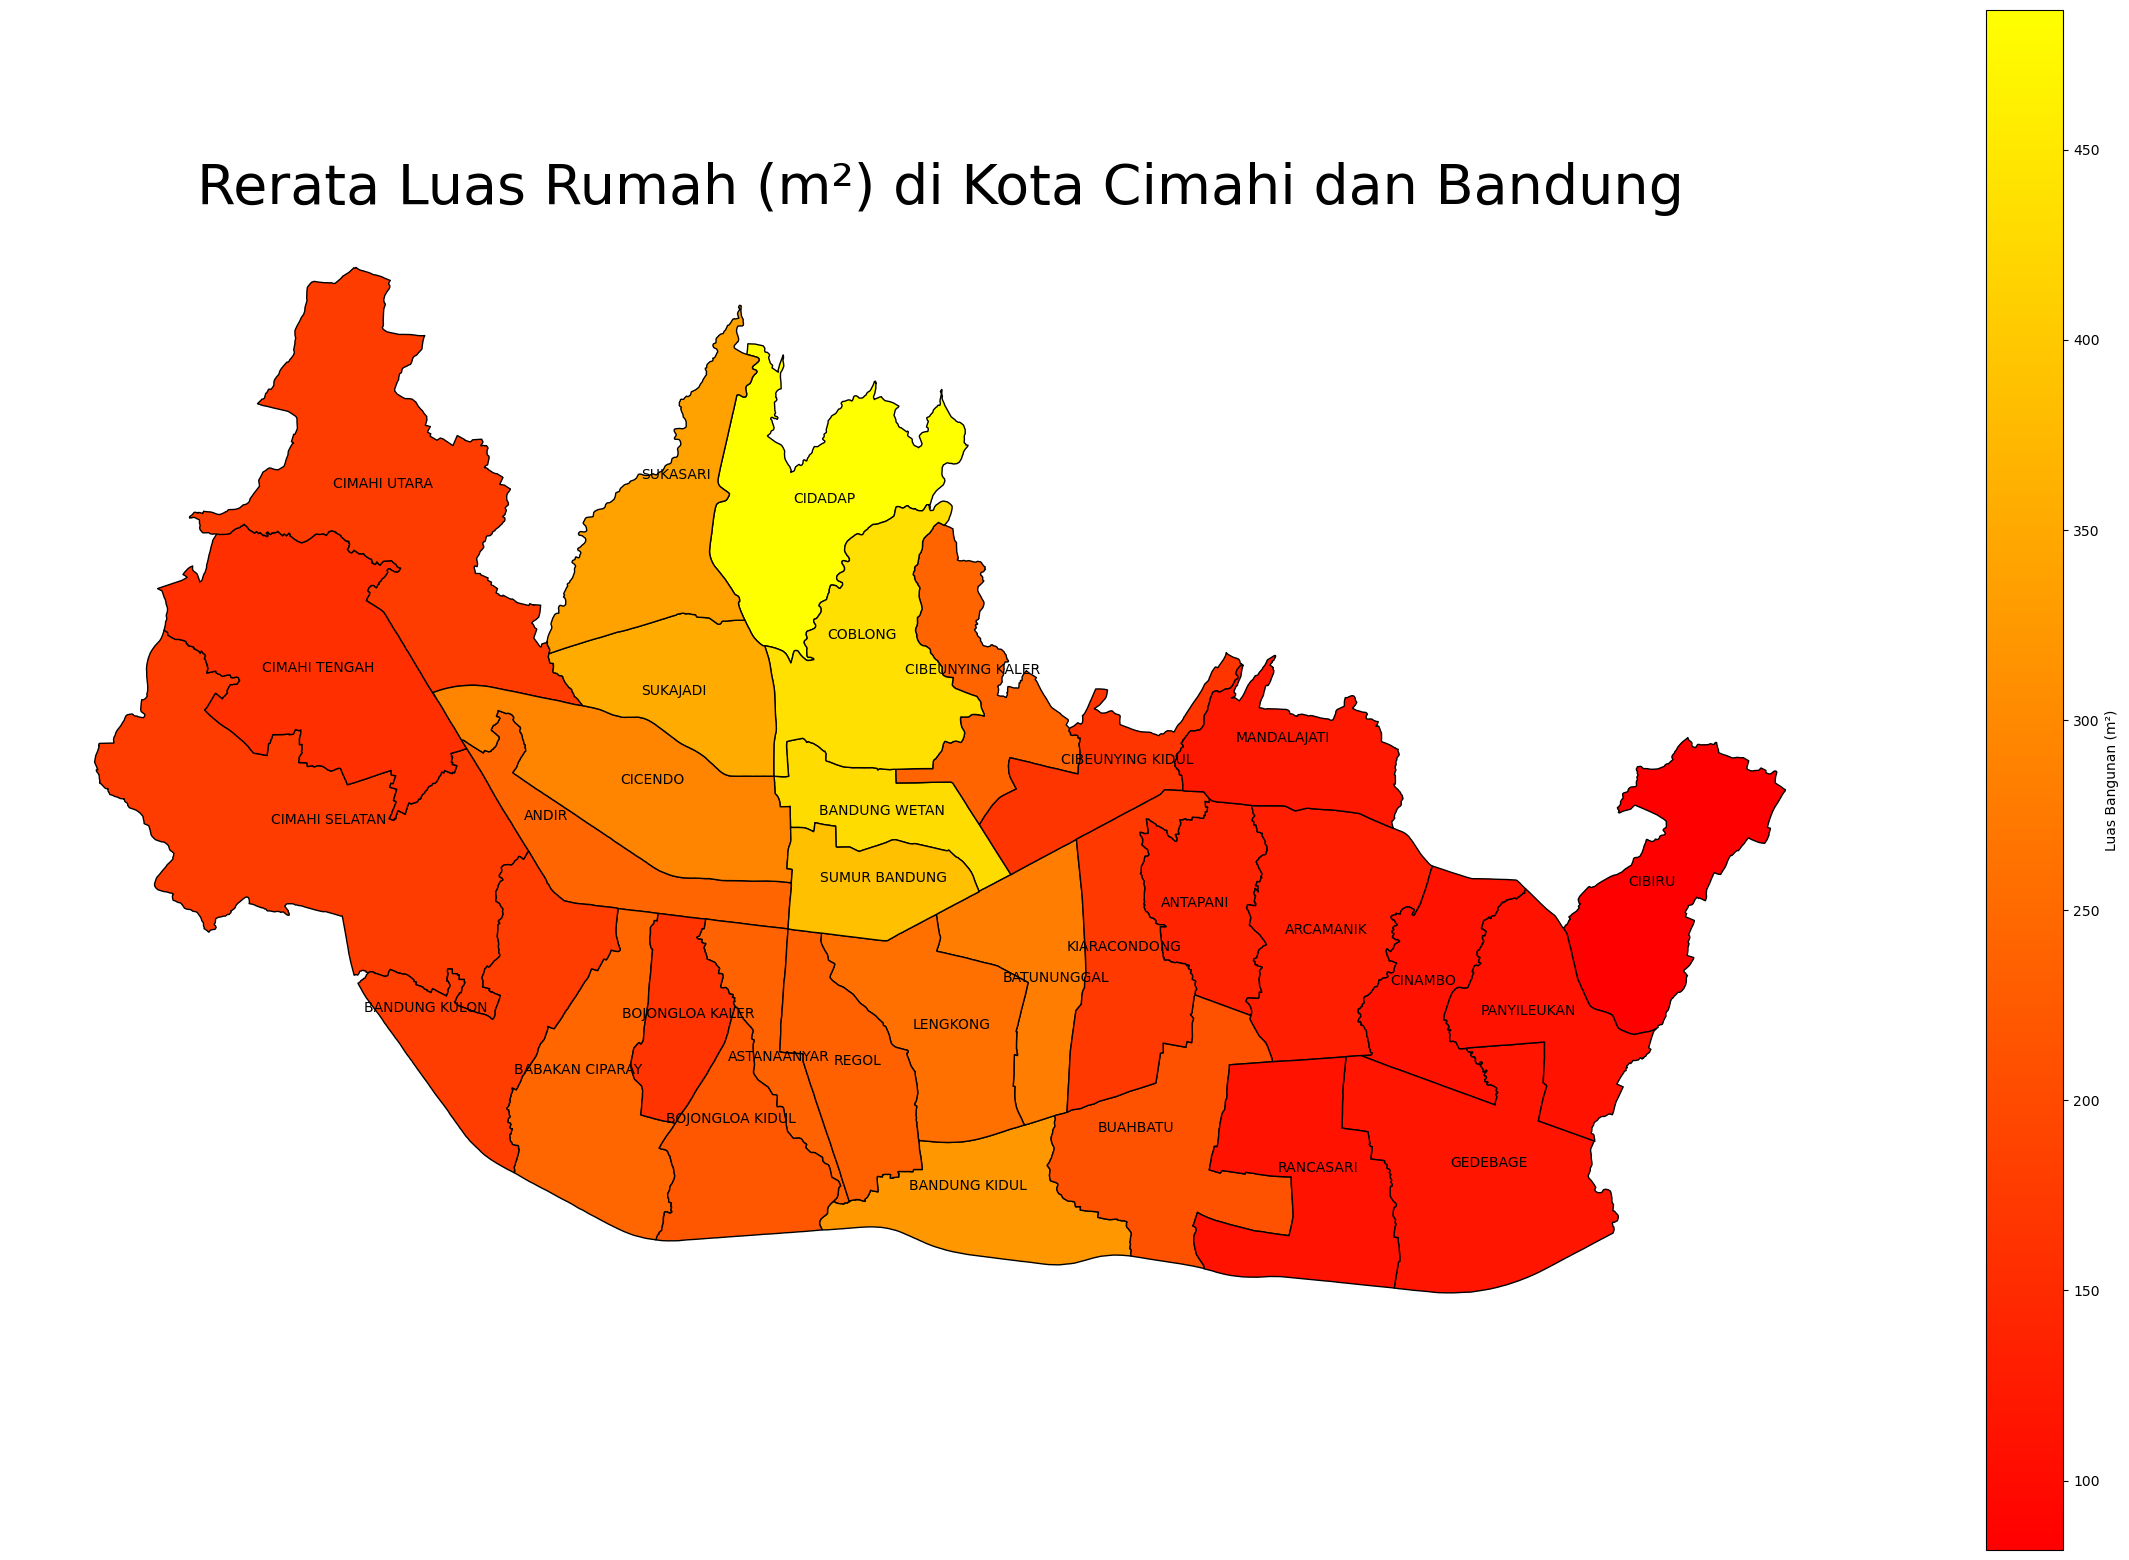

In [38]:
# Merge data Luas Rumah
cimahi_vis = cimahi.merge(luas_per_kecamatan_cimahi, left_on = 'KECAMATAN', right_on = 'Kecamatan', how = 'inner')
bandung_vis = bandung.merge(luas_per_kecamatan_bdg, left_on = 'KECAMATAN', right_on = 'Kecamatan', how = 'inner')
vis = pd.concat([cimahi_vis, bandung_vis], axis = 0, ignore_index = True)

# Plot
vis.plot(column="Rerata Luas (m²)", 
         figsize = (30,20), 
         cmap="autumn", 
         edgecolor="k", 
         legend=True,
         legend_kwds={"label": "Luas Bangunan (m²)"})
for idx, row in vis.iterrows():
    plt.annotate(text=row['KECAMATAN'], xy=row['coords'], horizontalalignment='center')
plt.title('Rerata Luas Rumah (m²) di Kota Cimahi dan Bandung', fontsize = 40)
plt.axis('off')
plt.show()